# Import Library

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from collections import Counter
import torchvision.models as models
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset

# Read Dataset

In [6]:
TRAIN_PATH = 'dataset/train/_annotations.csv'
TEST_PATH = 'dataset/test/_annotations.csv'
VALIDATION_PATH = 'dataset/valid/_annotations.csv'

TRAIN_IMAGES_PATH = 'dataset/train/images'
TEST_IMAGES_PATH = 'dataset/test/images'
VALIDATION_IMAGES_PATH = 'dataset/valid/images'

In [7]:
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,51c6a730cd2148cf_png.rf.8215c534a6a8965f48d3e4...,640,640,bald,144,136,463,296
1,0d68b408f99447db_png.rf.84b31c06c89c39aad59b37...,640,640,stage1,185,120,601,296
2,12c25ef865bb42f4_png.rf.83d97fda3647150ce7010b...,640,640,bald,191,121,494,291
3,2c8b63c20ae04544_png.rf.861ef2f7d5f4438094f21b...,640,640,stage1,166,153,557,284
4,5bf1b66a759e4a1d_png.rf.8532dba20adb44f0cd5ef8...,640,640,bald,138,88,483,286


In [8]:
test_data = pd.read_csv(TEST_PATH)
test_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,00f3803234f94362_png.rf.e19436380b41524690b06c...,640,640,stage2,147,77,516,287
1,06c6d8af209045ef_png.rf.f7fbfa579a3a986abb8ffc...,640,640,stage2,40,99,474,290
2,7b1a7bac342744e8_png.rf.ef38c4ac0cd88b3bb7128d...,640,640,stage2,111,105,476,294
3,4fa4cfaf860a4893_png.rf.e452ffa7501a295ae74fb5...,640,640,normal,55,95,512,293
4,6ff56310cb404774_png.rf.e9a3dfa46ca8d389bd0591...,640,640,stage2,102,63,520,298


In [9]:
validation_data = pd.read_csv(VALIDATION_PATH)
validation_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0c63639f8c0843e3_png.rf.1dc3b347beb1ced4e7080a...,640,640,stage1,133,113,521,291
1,5dd62b25c1cb49b0_png.rf.1f9a77f9d4295ad8600f54...,640,640,bald,152,137,502,296
2,9eadac6f97af49db_png.rf.288efbcbfb431f8e812924...,640,640,stage1,165,93,538,273
3,61b7fb0523694b9f_png.rf.1e15424d1b370d3f33dcf3...,640,640,normal,184,145,548,278
4,0c63dee11a5f4714_png.rf.2593b9e6550e8183e3c33e...,640,640,stage1,109,61,508,287


In [10]:
def storeImagesAnnotation(data, images_path, show_labels='training'):
    # Create lists to store the images and their respective labels
    images = []
    labels = []
    total_rows = len(data)
    # Loop through each row in the dataframe
    for _, row in tqdm(data.iterrows(), total=total_rows, desc=f'Processing Images of {show_labels} set'):
        image_path = os.path.join(images_path, row['filename'])

        # Read the image using OpenCV
        image = cv2.imread(image_path)

        images.append(image)
        labels.append(row['class'])

    return images, labels

def showImages(images, labels, n_images=10):
    n_cols = (n_images + 1) // 2
    n_rows = 2

    fig_width = 15
    fig_height = (n_rows / 2) * 7
    # Read images of grayscale
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(n_images):
        fig.add_subplot(n_rows, n_cols, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

In [11]:
train_images, train_labels = storeImagesAnnotation(train_data, TRAIN_IMAGES_PATH)
test_images, test_labels = storeImagesAnnotation(test_data, TEST_IMAGES_PATH, show_labels='test')
validation_images, validation_labels = storeImagesAnnotation(validation_data, VALIDATION_IMAGES_PATH, show_labels='validation')

Processing Images of validation set: 100%|██████████| 302/302 [00:03<00:00, 92.66it/s] 


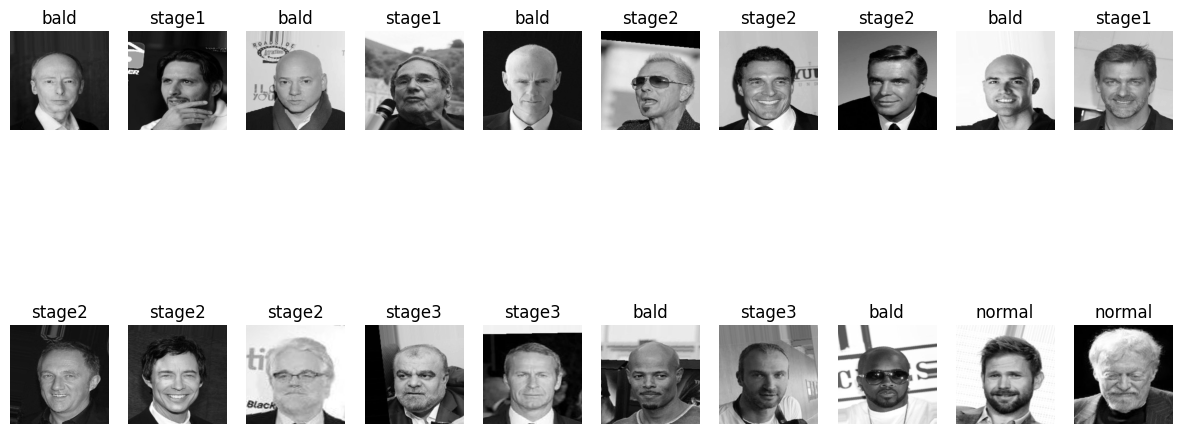

In [9]:
showImages(train_images, train_labels, 20)

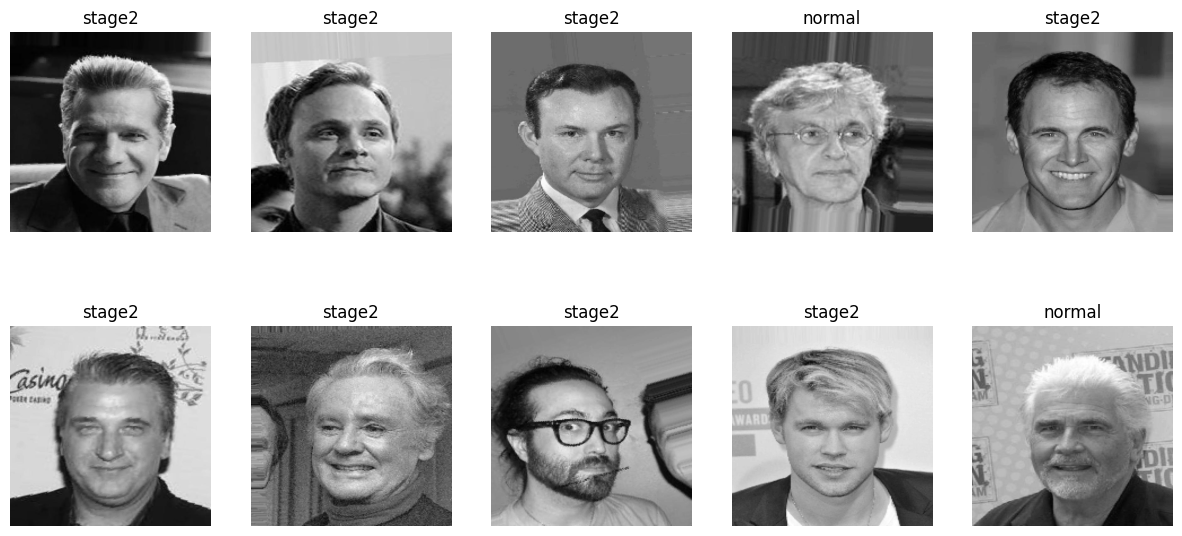

In [10]:
showImages(test_images, test_labels, 10)

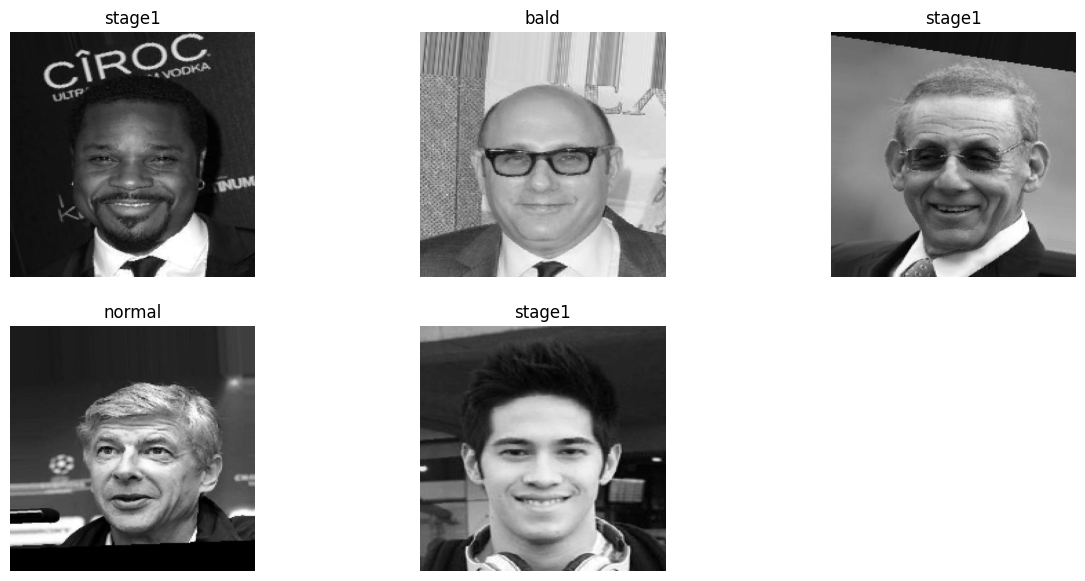

In [11]:
showImages(validation_images, validation_labels, 5)

In [12]:
list(set(train_labels))

['bald', 'normal', 'stage2', 'stage3', 'stage1']

In [98]:
def countLabels(labels):
    label_counts = Counter(labels)
    for label, count in label_counts.items():
        print(f"Label '{label}': {count}")

def plotClassDistributionPie(labels):
    label_counts = Counter(labels)
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')

def plotClassDistributionCountPlot(labels):
    sns.countplot(x=labels, hue=labels, palette='Set3', legend=False)
    plt.xlabel('Label')
    plt.ylabel('Count')


In [101]:
countLabels(train_labels)

Label 'bald': 298
Label 'stage1': 307
Label 'stage2': 296
Label 'stage3': 318
Label 'normal': 302


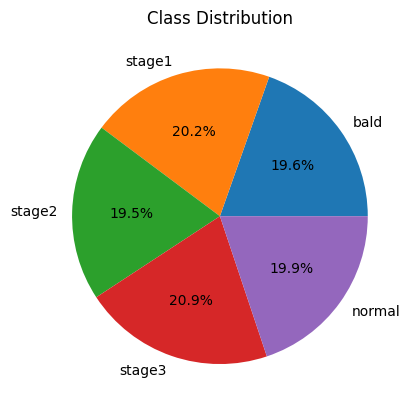

In [99]:
plotClassDistributionPie(train_labels)

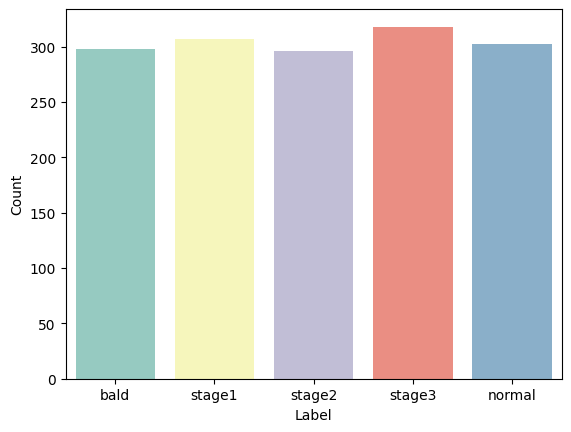

In [100]:
plotClassDistributionCountPlot(train_labels)

In [102]:
countLabels(test_labels)

Label 'stage2': 82
Label 'normal': 58
Label 'stage3': 66
Label 'bald': 41
Label 'stage1': 56


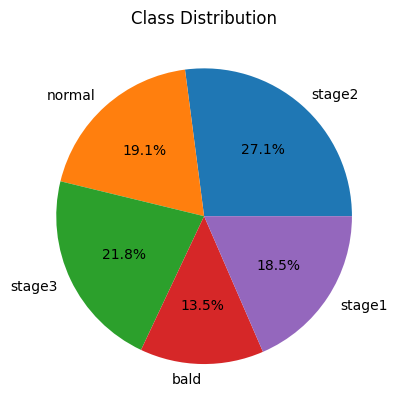

In [93]:
plotClassDistributionPie(test_labels)

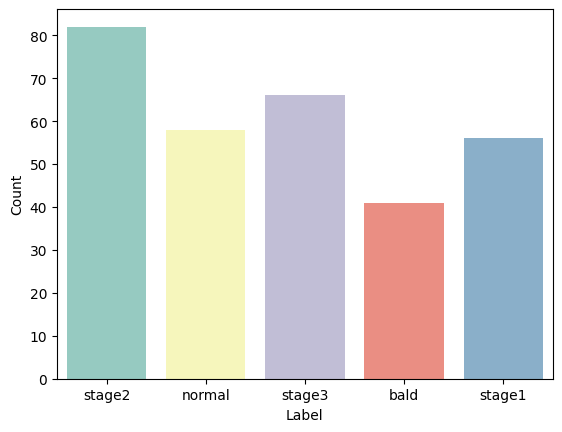

In [94]:
plotClassDistributionCountPlot(test_labels)

In [103]:
countLabels(validation_labels)

Label 'stage1': 63
Label 'bald': 86
Label 'normal': 65
Label 'stage3': 41
Label 'stage2': 47


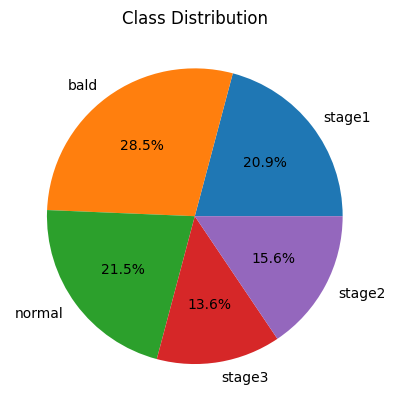

In [104]:
plotClassDistributionPie(validation_labels)

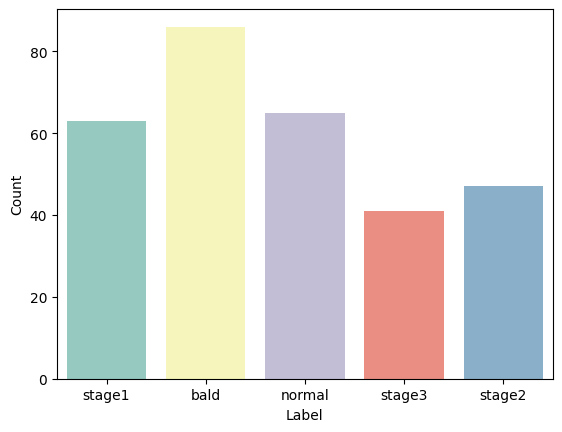

In [105]:
plotClassDistributionCountPlot(validation_labels)

# Pre-process Data

Define functions to resize images into 28x28, apply grayscale, reshape images and then normalize data

In [321]:
def resizeImages(images_train=train_images, images_test=test_images, images_validation=validation_images, new_height=28, new_width=28):
    resized_train_images = [cv2.resize(img, (new_width, new_height)) for img in images_train]
    resized_test_images = [cv2.resize(img, (new_width, new_height)) for img in images_test]
    resized_validation_images = [cv2.resize(img, (new_width, new_height)) for img in images_validation]
    return np.array(resized_train_images), np.array(resized_test_images), np.array(resized_validation_images)

def grayscaleImages(images_train, images_test, images_validation):
    grayscale_images_train = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_train]
    grayscale_images_test = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_test]
    grayscale_images_validation = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_validation]
    return np.array(grayscale_images_train), np.array(grayscale_images_test), np.array(grayscale_images_validation)

def reshapeImages(train_images, test_images, validation_images, grayscale=False):
    if grayscale:
        height, width = train_images.shape[1], train_images.shape[2]
        num_features = 1
    else:
        height, width = train_images.shape[2], train_images.shape[3]
        num_features = train_images.shape[1]

    X_train = train_images.reshape(train_images.shape[0], num_features, height, width).astype('float32')
    X_test = test_images.reshape(test_images.shape[0], num_features, height, width).astype('float32')
    X_validation = validation_images.reshape(validation_images.shape[0], num_features, height, width).astype('float32')
    return X_train, X_test, X_validation

def normalizeData(train_images, test_images, validation_images):
    X_train = train_images / 255
    X_test = test_images / 255
    X_validation = validation_images / 255
    return X_train, X_test, X_validation

def categoricalImages(train_labels=train_labels, test_labels=test_labels, validation_labels=validation_labels):
    y_train = to_categorical(train_labels)
    y_test = to_categorical(test_labels)
    y_validation = to_categorical(validation_labels)
    return y_train, y_test, y_validation

def preprocessData(train_labels=train_labels, test_labels=test_labels, validation_labels=validation_labels, categorical=True):
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)
    validation_labels_encoded = label_encoder.transform(validation_labels)
    if categorical:
        y_train, y_test, y_validation = categoricalImages(train_labels_encoded, test_labels_encoded, validation_labels_encoded)
    else:
        y_train, y_test, y_validation = train_labels_encoded, test_labels_encoded, validation_labels_encoded
    return y_train, y_test, y_validation

def mainProcessData(dim_res=28, grayscale=False):
    X_train_resized, X_test_resized, X_validation_resized = resizeImages(train_images, test_images, validation_images, dim_res, dim_res)
    
    if grayscale:
        X_train_grayscale, X_test_grayscale, X_validation_grayscale = grayscaleImages(X_train_resized, X_test_resized, X_validation_resized)
        X_train_reshaped, X_test_reshaped, X_validation_reshaped = reshapeImages(X_train_grayscale, X_test_grayscale, X_validation_grayscale, grayscale=True)
    else:
        X_train_reshaped, X_test_reshaped, X_validation_reshaped = reshapeImages(X_train_resized, X_test_resized, X_validation_resized)
        
    X_train_normalize, X_test_normalize, X_validation_normalize = normalizeData(X_train_reshaped, X_test_reshaped, X_validation_reshaped)
    y_train, y_test, y_validation = preprocessData()

    return X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation

def toFloat(train_images, test_images, validation_images):
    X_train = train_images.astype('float32')
    X_test = test_images.astype('float32')
    X_validation = validation_images.astype('float32')
    return X_train, X_test, X_validation

def mainProcessData2(train_images=train_images, test_images=test_images, validation_images=validation_images, train_labels=train_labels, test_labels=test_labels, validation_labels=validation_labels,dim_res=28, grayscale=False, preprocess_y=True):
    X_train_resized, X_test_resized, X_validation_resized = resizeImages(train_images, test_images, validation_images, dim_res, dim_res)
    
    if grayscale:
        X_train_grayscale, X_test_grayscale, X_validation_grayscale = grayscaleImages(X_train_resized, X_test_resized, X_validation_resized)
    else:
        X_train_grayscale, X_test_grayscale, X_validation_grayscale = X_train_resized, X_test_resized, X_validation_resized

    X_train_reshaped, X_test_reshaped, X_validation_reshaped = toFloat(X_train_grayscale, X_test_grayscale, X_validation_grayscale)
    X_train_normalize, X_test_normalize, X_validation_normalize = normalizeData(X_train_reshaped, X_test_reshaped, X_validation_reshaped)
    y_train, y_test, y_validation = preprocessData(train_labels, test_labels, validation_labels, preprocess_y)
    return X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation


In [13]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData(dim_res=32)
X_train_normalize.shape

(1521, 32, 32, 3)

Convert Numpy to Tensor and define data loader

In [14]:
def convertToTensor(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, X_validation_normalize=X_validation_normalize, y_train=y_train, y_test=y_test, y_validation=y_validation):
  X_train_tensor = torch.tensor(X_train_normalize, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  X_validation_tensor = torch.tensor(X_validation_normalize, dtype=torch.float32)
  y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test_normalize, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  return X_train_tensor, y_train_tensor, X_validation_tensor, y_validation_tensor, X_test_tensor, y_test_tensor

def defineDataLoader(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, X_validation_normalize=X_validation_normalize, y_train=y_train, y_test=y_test, y_validation=y_validation, batch_size=32):
  X_train_tensor, y_train_tensor, X_validation_tensor, y_validation_tensor, X_test_tensor, y_test_tensor = convertToTensor(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, X_validation_normalize=X_validation_normalize, y_train=y_train, y_test=y_test, y_validation=y_validation)
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, validation_loader, test_loader

def convertToTensor2(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, y_train=y_train, y_test=y_test):
  X_train_tensor = torch.tensor(X_train_normalize, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test_normalize, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

def defineDataLoader2(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, y_train=y_train, y_test=y_test, batch_size=32):
  X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convertToTensor2(X_train_normalize=X_train_normalize, X_test_normalize=X_test_normalize, y_train=y_train, y_test=y_test)
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [11]:
train_loader, validation_loader, test_loader = defineDataLoader()

# Modelling

## Build Architecture

### 1 Model With 3 Channel

In [132]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=40)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
X_train_normalize.shape

(1823, 40, 40, 3)

In [133]:
train_loader, test_loader = defineDataLoader2(X_train_normalize, X_test_normalize, y_train, y_test, batch_size=32)
for inputs, labels in train_loader:
    print(f"Shape of input: {inputs.shape}")
    print(f"Type of input: {inputs.dtype}")
    break

Shape of input: torch.Size([32, 40, 40, 3])
Type of input: torch.float32


In [137]:
class CNN_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.flat = nn.Flatten()
        self.fc3 = nn.Linear(14112, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 5)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

In [138]:
model_1 = CNN_1()
model_1

CNN_1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=14112, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=5, bias=True)
)

In [139]:
summary(model_1, (40, 40, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]             896
              ReLU-2           [-1, 32, 40, 40]               0
           Dropout-3           [-1, 32, 40, 40]               0
            Conv2d-4           [-1, 32, 40, 40]           9,248
              ReLU-5           [-1, 32, 40, 40]               0
         MaxPool2d-6           [-1, 32, 21, 21]               0
           Flatten-7                [-1, 14112]               0
            Linear-8                  [-1, 512]       7,225,856
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 5]           2,565
Total params: 7,238,565
Trainable params: 7,238,565
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

## Training model

In [146]:
def extractAccuracyAvgLoss(model, dataloader, criterion):
    model.eval()
    all_predictions = []
    all_targets = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, dim=1)
            all_predictions.extend(predictions.tolist())
            labels = torch.argmax(labels, dim=1)
            all_targets.extend(labels.tolist())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    all_predictions = torch.tensor(all_predictions)
    all_targets = torch.tensor(all_targets)

    accuracy = accuracy_score(all_targets, all_predictions)
    avg_loss = running_loss / len(dataloader)

    return accuracy, avg_loss

def trainModel(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, patience=20, min_lr=1e-6):
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, min_lr=min_lr)
    best_loss = float('inf')
    epochs_without_improvement = 0
    history_train_loss = []
    history_test_loss = []
    history_train_accuracy = []
    history_test_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in train_loader_iter:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels.argmax(dim=1)).sum().item()

            train_loader_iter.set_postfix(train_loss=loss.item())

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        history_train_loss.append(train_loss)
        history_train_accuracy.append(train_accuracy)

        # Evaluate on test set
        test_accuracy, test_loss = extractAccuracyAvgLoss(model, test_loader, criterion)
        history_test_loss.append(test_loss)
        history_test_accuracy.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

        # Update learning rate
        scheduler.step(test_loss)

        # Check early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Training stopped: no improvement for {patience} consecutive epochs.")
            break
    
    return history_train_loss, history_test_loss, history_train_accuracy, history_test_accuracy

def plot_loss(history_train_loss, history_test_loss):
    epochs = range(1, len(history_train_loss) + 1)
    plt.plot(epochs, history_train_loss, label='Training Loss')
    plt.plot(epochs, history_test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()

def plot_accuracy(history_train_accuracy, history_test_accuracy):
    epochs = range(1, len(history_train_accuracy) + 1)
    plt.plot(epochs, history_train_accuracy, label='Accuracy Training')
    plt.plot(epochs, history_test_accuracy, label='Accuracy Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Epochs')
    plt.legend()
    plt.show()

In [147]:
model_1 = CNN_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001)
history_train_loss, history_test_loss, history_train_accuracy, history_test_accuracy = trainModel(model_1, train_loader, test_loader, criterion, optimizer, num_epochs=100)

Epoch 1/100:   5%|▌         | 3/57 [00:00<00:02, 23.71it/s, train_loss=1.62]

Epoch 1/100: 100%|██████████| 57/57 [00:03<00:00, 17.78it/s, train_loss=1.61]


Epoch [1/100], Train Loss: 1.6093, Train Acc: 0.2019, Test Loss: 1.6109, Test Acc: 0.2211


Epoch 2/100: 100%|██████████| 57/57 [00:02<00:00, 19.09it/s, train_loss=1.61]


Epoch [2/100], Train Loss: 1.6098, Train Acc: 0.1892, Test Loss: 1.6111, Test Acc: 0.2145


Epoch 3/100: 100%|██████████| 57/57 [00:02<00:00, 19.55it/s, train_loss=1.61]


Epoch [3/100], Train Loss: 1.6073, Train Acc: 0.2156, Test Loss: 1.6113, Test Acc: 0.2013


Epoch 4/100: 100%|██████████| 57/57 [00:02<00:00, 19.48it/s, train_loss=1.6] 


Epoch [4/100], Train Loss: 1.6066, Train Acc: 0.2194, Test Loss: 1.6115, Test Acc: 0.2013


Epoch 5/100: 100%|██████████| 57/57 [00:03<00:00, 18.55it/s, train_loss=1.61]


Epoch [5/100], Train Loss: 1.6068, Train Acc: 0.2276, Test Loss: 1.6115, Test Acc: 0.2112


Epoch 6/100: 100%|██████████| 57/57 [00:02<00:00, 19.43it/s, train_loss=1.61]


Epoch [6/100], Train Loss: 1.6071, Train Acc: 0.2271, Test Loss: 1.6115, Test Acc: 0.2079


Epoch 7/100: 100%|██████████| 57/57 [00:02<00:00, 20.48it/s, train_loss=1.61]


Epoch [7/100], Train Loss: 1.6061, Train Acc: 0.2342, Test Loss: 1.6115, Test Acc: 0.2046


Epoch 8/100: 100%|██████████| 57/57 [00:02<00:00, 21.89it/s, train_loss=1.61]


Epoch [8/100], Train Loss: 1.6063, Train Acc: 0.2260, Test Loss: 1.6114, Test Acc: 0.2178


Epoch 9/100: 100%|██████████| 57/57 [00:02<00:00, 19.54it/s, train_loss=1.61]


Epoch [9/100], Train Loss: 1.6047, Train Acc: 0.2430, Test Loss: 1.6113, Test Acc: 0.2145


Epoch 10/100: 100%|██████████| 57/57 [00:02<00:00, 20.59it/s, train_loss=1.61]


Epoch [10/100], Train Loss: 1.6045, Train Acc: 0.2589, Test Loss: 1.6113, Test Acc: 0.2079


Epoch 11/100: 100%|██████████| 57/57 [00:02<00:00, 20.60it/s, train_loss=1.6] 


Epoch [11/100], Train Loss: 1.6039, Train Acc: 0.2463, Test Loss: 1.6111, Test Acc: 0.2079


Epoch 12/100: 100%|██████████| 57/57 [00:02<00:00, 21.12it/s, train_loss=1.62]


Epoch [12/100], Train Loss: 1.6031, Train Acc: 0.2617, Test Loss: 1.6109, Test Acc: 0.2145


Epoch 13/100: 100%|██████████| 57/57 [00:02<00:00, 20.48it/s, train_loss=1.61]


Epoch [13/100], Train Loss: 1.6027, Train Acc: 0.2562, Test Loss: 1.6108, Test Acc: 0.2211


Epoch 14/100: 100%|██████████| 57/57 [00:02<00:00, 20.36it/s, train_loss=1.61]


Epoch [14/100], Train Loss: 1.6022, Train Acc: 0.2490, Test Loss: 1.6108, Test Acc: 0.2145


Epoch 15/100: 100%|██████████| 57/57 [00:02<00:00, 21.43it/s, train_loss=1.59]


Epoch [15/100], Train Loss: 1.6011, Train Acc: 0.2584, Test Loss: 1.6107, Test Acc: 0.2178


Epoch 16/100: 100%|██████████| 57/57 [00:02<00:00, 20.49it/s, train_loss=1.61]


Epoch [16/100], Train Loss: 1.6005, Train Acc: 0.2578, Test Loss: 1.6105, Test Acc: 0.2178


Epoch 17/100: 100%|██████████| 57/57 [00:02<00:00, 20.23it/s, train_loss=1.6] 


Epoch [17/100], Train Loss: 1.5997, Train Acc: 0.2584, Test Loss: 1.6101, Test Acc: 0.2178


Epoch 18/100: 100%|██████████| 57/57 [00:02<00:00, 21.24it/s, train_loss=1.58]


Epoch [18/100], Train Loss: 1.5990, Train Acc: 0.2600, Test Loss: 1.6099, Test Acc: 0.2244


Epoch 19/100: 100%|██████████| 57/57 [00:02<00:00, 21.10it/s, train_loss=1.6] 


Epoch [19/100], Train Loss: 1.5987, Train Acc: 0.2671, Test Loss: 1.6094, Test Acc: 0.2310


Epoch 20/100: 100%|██████████| 57/57 [00:02<00:00, 19.99it/s, train_loss=1.59]


Epoch [20/100], Train Loss: 1.5976, Train Acc: 0.2666, Test Loss: 1.6091, Test Acc: 0.2277


Epoch 21/100: 100%|██████████| 57/57 [00:02<00:00, 20.73it/s, train_loss=1.6] 


Epoch [21/100], Train Loss: 1.5953, Train Acc: 0.2902, Test Loss: 1.6087, Test Acc: 0.2376


Epoch 22/100: 100%|██████████| 57/57 [00:03<00:00, 17.99it/s, train_loss=1.6] 


Epoch [22/100], Train Loss: 1.5951, Train Acc: 0.2940, Test Loss: 1.6083, Test Acc: 0.2343


Epoch 23/100: 100%|██████████| 57/57 [00:02<00:00, 19.59it/s, train_loss=1.62]


Epoch [23/100], Train Loss: 1.5945, Train Acc: 0.2809, Test Loss: 1.6077, Test Acc: 0.2409


Epoch 24/100: 100%|██████████| 57/57 [00:02<00:00, 19.06it/s, train_loss=1.59]


Epoch [24/100], Train Loss: 1.5928, Train Acc: 0.2935, Test Loss: 1.6074, Test Acc: 0.2442


Epoch 25/100: 100%|██████████| 57/57 [00:03<00:00, 18.65it/s, train_loss=1.57]


Epoch [25/100], Train Loss: 1.5922, Train Acc: 0.3033, Test Loss: 1.6067, Test Acc: 0.2376


Epoch 26/100: 100%|██████████| 57/57 [00:03<00:00, 17.69it/s, train_loss=1.59]


Epoch [26/100], Train Loss: 1.5892, Train Acc: 0.2990, Test Loss: 1.6063, Test Acc: 0.2442


Epoch 27/100: 100%|██████████| 57/57 [00:03<00:00, 15.94it/s, train_loss=1.6] 


Epoch [27/100], Train Loss: 1.5895, Train Acc: 0.3099, Test Loss: 1.6054, Test Acc: 0.2475


Epoch 28/100: 100%|██████████| 57/57 [00:03<00:00, 15.61it/s, train_loss=1.59]


Epoch [28/100], Train Loss: 1.5880, Train Acc: 0.3039, Test Loss: 1.6042, Test Acc: 0.2541


Epoch 29/100: 100%|██████████| 57/57 [00:04<00:00, 13.82it/s, train_loss=1.6] 


Epoch [29/100], Train Loss: 1.5877, Train Acc: 0.3055, Test Loss: 1.6032, Test Acc: 0.2541


Epoch 30/100: 100%|██████████| 57/57 [00:03<00:00, 16.90it/s, train_loss=1.58]


Epoch [30/100], Train Loss: 1.5836, Train Acc: 0.3242, Test Loss: 1.6024, Test Acc: 0.2541


Epoch 31/100: 100%|██████████| 57/57 [00:03<00:00, 16.73it/s, train_loss=1.56]


Epoch [31/100], Train Loss: 1.5831, Train Acc: 0.3204, Test Loss: 1.6014, Test Acc: 0.2607


Epoch 32/100: 100%|██████████| 57/57 [00:03<00:00, 16.68it/s, train_loss=1.57]


Epoch [32/100], Train Loss: 1.5793, Train Acc: 0.3363, Test Loss: 1.6003, Test Acc: 0.2673


Epoch 33/100: 100%|██████████| 57/57 [00:03<00:00, 16.44it/s, train_loss=1.58]


Epoch [33/100], Train Loss: 1.5785, Train Acc: 0.3297, Test Loss: 1.5990, Test Acc: 0.2607


Epoch 34/100: 100%|██████████| 57/57 [00:03<00:00, 15.72it/s, train_loss=1.55]


Epoch [34/100], Train Loss: 1.5758, Train Acc: 0.3324, Test Loss: 1.5970, Test Acc: 0.2607


Epoch 35/100: 100%|██████████| 57/57 [00:03<00:00, 16.75it/s, train_loss=1.55]


Epoch [35/100], Train Loss: 1.5720, Train Acc: 0.3313, Test Loss: 1.5949, Test Acc: 0.2607


Epoch 36/100: 100%|██████████| 57/57 [00:03<00:00, 16.28it/s, train_loss=1.56]


Epoch [36/100], Train Loss: 1.5710, Train Acc: 0.3456, Test Loss: 1.5932, Test Acc: 0.2739


Epoch 37/100: 100%|██████████| 57/57 [00:03<00:00, 16.96it/s, train_loss=1.59]


Epoch [37/100], Train Loss: 1.5669, Train Acc: 0.3417, Test Loss: 1.5917, Test Acc: 0.2805


Epoch 38/100: 100%|██████████| 57/57 [00:03<00:00, 17.21it/s, train_loss=1.6] 


Epoch [38/100], Train Loss: 1.5647, Train Acc: 0.3258, Test Loss: 1.5903, Test Acc: 0.2805


Epoch 39/100: 100%|██████████| 57/57 [00:03<00:00, 15.79it/s, train_loss=1.58]


Epoch [39/100], Train Loss: 1.5594, Train Acc: 0.3467, Test Loss: 1.5872, Test Acc: 0.3069


Epoch 40/100: 100%|██████████| 57/57 [00:03<00:00, 16.80it/s, train_loss=1.54]


Epoch [40/100], Train Loss: 1.5545, Train Acc: 0.3516, Test Loss: 1.5863, Test Acc: 0.2871


Epoch 41/100: 100%|██████████| 57/57 [00:03<00:00, 17.74it/s, train_loss=1.56]


Epoch [41/100], Train Loss: 1.5507, Train Acc: 0.3467, Test Loss: 1.5828, Test Acc: 0.2904


Epoch 42/100: 100%|██████████| 57/57 [00:03<00:00, 14.98it/s, train_loss=1.5] 


Epoch [42/100], Train Loss: 1.5458, Train Acc: 0.3533, Test Loss: 1.5806, Test Acc: 0.2772


Epoch 43/100: 100%|██████████| 57/57 [00:03<00:00, 17.77it/s, train_loss=1.52]


Epoch [43/100], Train Loss: 1.5427, Train Acc: 0.3582, Test Loss: 1.5762, Test Acc: 0.3036


Epoch 44/100: 100%|██████████| 57/57 [00:03<00:00, 17.15it/s, train_loss=1.53]


Epoch [44/100], Train Loss: 1.5364, Train Acc: 0.3582, Test Loss: 1.5748, Test Acc: 0.2871


Epoch 45/100: 100%|██████████| 57/57 [00:03<00:00, 17.12it/s, train_loss=1.49]


Epoch [45/100], Train Loss: 1.5294, Train Acc: 0.3516, Test Loss: 1.5728, Test Acc: 0.2739


Epoch 46/100: 100%|██████████| 57/57 [00:03<00:00, 17.74it/s, train_loss=1.58]


Epoch [46/100], Train Loss: 1.5276, Train Acc: 0.3615, Test Loss: 1.5709, Test Acc: 0.2871


Epoch 47/100: 100%|██████████| 57/57 [00:03<00:00, 17.58it/s, train_loss=1.58]


Epoch [47/100], Train Loss: 1.5238, Train Acc: 0.3478, Test Loss: 1.5626, Test Acc: 0.3168


Epoch 48/100: 100%|██████████| 57/57 [00:03<00:00, 17.90it/s, train_loss=1.52]


Epoch [48/100], Train Loss: 1.5152, Train Acc: 0.3675, Test Loss: 1.5648, Test Acc: 0.2904


Epoch 49/100: 100%|██████████| 57/57 [00:03<00:00, 17.42it/s, train_loss=1.45]


Epoch [49/100], Train Loss: 1.5102, Train Acc: 0.3626, Test Loss: 1.5590, Test Acc: 0.3267


Epoch 50/100: 100%|██████████| 57/57 [00:03<00:00, 16.78it/s, train_loss=1.51]


Epoch [50/100], Train Loss: 1.5025, Train Acc: 0.3555, Test Loss: 1.5553, Test Acc: 0.3135


Epoch 51/100: 100%|██████████| 57/57 [00:03<00:00, 18.06it/s, train_loss=1.45]


Epoch [51/100], Train Loss: 1.4950, Train Acc: 0.3615, Test Loss: 1.5561, Test Acc: 0.2937


Epoch 52/100: 100%|██████████| 57/57 [00:03<00:00, 16.53it/s, train_loss=1.42]


Epoch [52/100], Train Loss: 1.4927, Train Acc: 0.3615, Test Loss: 1.5514, Test Acc: 0.3003


Epoch 53/100: 100%|██████████| 57/57 [00:03<00:00, 16.07it/s, train_loss=1.52]


Epoch [53/100], Train Loss: 1.4801, Train Acc: 0.3703, Test Loss: 1.5507, Test Acc: 0.3399


Epoch 54/100: 100%|██████████| 57/57 [00:03<00:00, 17.00it/s, train_loss=1.4] 


Epoch [54/100], Train Loss: 1.4821, Train Acc: 0.3648, Test Loss: 1.5402, Test Acc: 0.3333


Epoch 55/100: 100%|██████████| 57/57 [00:03<00:00, 14.89it/s, train_loss=1.5] 


Epoch [55/100], Train Loss: 1.4766, Train Acc: 0.3747, Test Loss: 1.5360, Test Acc: 0.3465


Epoch 56/100: 100%|██████████| 57/57 [00:03<00:00, 15.70it/s, train_loss=1.43]


Epoch [56/100], Train Loss: 1.4652, Train Acc: 0.3741, Test Loss: 1.5347, Test Acc: 0.3366


Epoch 57/100: 100%|██████████| 57/57 [00:03<00:00, 16.44it/s, train_loss=1.53]


Epoch [57/100], Train Loss: 1.4614, Train Acc: 0.3725, Test Loss: 1.5436, Test Acc: 0.3399


Epoch 58/100: 100%|██████████| 57/57 [00:03<00:00, 16.82it/s, train_loss=1.47]


Epoch [58/100], Train Loss: 1.4587, Train Acc: 0.3659, Test Loss: 1.5293, Test Acc: 0.3531


Epoch 59/100: 100%|██████████| 57/57 [00:03<00:00, 16.45it/s, train_loss=1.42]


Epoch [59/100], Train Loss: 1.4521, Train Acc: 0.3758, Test Loss: 1.5279, Test Acc: 0.3333


Epoch 60/100: 100%|██████████| 57/57 [00:03<00:00, 16.90it/s, train_loss=1.43]


Epoch [60/100], Train Loss: 1.4488, Train Acc: 0.3752, Test Loss: 1.5320, Test Acc: 0.3465


Epoch 61/100: 100%|██████████| 57/57 [00:03<00:00, 16.76it/s, train_loss=1.39]


Epoch [61/100], Train Loss: 1.4392, Train Acc: 0.3922, Test Loss: 1.5365, Test Acc: 0.3630


Epoch 62/100: 100%|██████████| 57/57 [00:03<00:00, 16.79it/s, train_loss=1.44]


Epoch [62/100], Train Loss: 1.4415, Train Acc: 0.3867, Test Loss: 1.5239, Test Acc: 0.3531


Epoch 63/100: 100%|██████████| 57/57 [00:03<00:00, 16.66it/s, train_loss=1.41]


Epoch [63/100], Train Loss: 1.4353, Train Acc: 0.3845, Test Loss: 1.5145, Test Acc: 0.3729


Epoch 64/100: 100%|██████████| 57/57 [00:03<00:00, 17.07it/s, train_loss=1.35]


Epoch [64/100], Train Loss: 1.4340, Train Acc: 0.3769, Test Loss: 1.5363, Test Acc: 0.3300


Epoch 65/100: 100%|██████████| 57/57 [00:03<00:00, 16.66it/s, train_loss=1.4] 


Epoch [65/100], Train Loss: 1.4217, Train Acc: 0.3889, Test Loss: 1.5074, Test Acc: 0.3399


Epoch 66/100: 100%|██████████| 57/57 [00:03<00:00, 16.21it/s, train_loss=1.43]


Epoch [66/100], Train Loss: 1.4257, Train Acc: 0.3801, Test Loss: 1.5184, Test Acc: 0.3366


Epoch 67/100: 100%|██████████| 57/57 [00:03<00:00, 17.42it/s, train_loss=1.21]


Epoch [67/100], Train Loss: 1.4257, Train Acc: 0.3834, Test Loss: 1.5093, Test Acc: 0.3795


Epoch 68/100: 100%|██████████| 57/57 [00:03<00:00, 18.61it/s, train_loss=1.28]


Epoch [68/100], Train Loss: 1.4181, Train Acc: 0.3933, Test Loss: 1.5222, Test Acc: 0.3399


Epoch 69/100: 100%|██████████| 57/57 [00:03<00:00, 17.10it/s, train_loss=1.45]


Epoch [69/100], Train Loss: 1.4140, Train Acc: 0.3774, Test Loss: 1.5080, Test Acc: 0.3267


Epoch 70/100: 100%|██████████| 57/57 [00:03<00:00, 18.00it/s, train_loss=1.22]


Epoch [70/100], Train Loss: 1.4139, Train Acc: 0.3982, Test Loss: 1.5175, Test Acc: 0.3630


Epoch 71/100: 100%|██████████| 57/57 [00:03<00:00, 17.40it/s, train_loss=1.35]


Epoch [71/100], Train Loss: 1.4128, Train Acc: 0.3977, Test Loss: 1.5083, Test Acc: 0.3663


Epoch 72/100: 100%|██████████| 57/57 [00:03<00:00, 17.95it/s, train_loss=1.2] 


Epoch [72/100], Train Loss: 1.4083, Train Acc: 0.4032, Test Loss: 1.5199, Test Acc: 0.3597


Epoch 73/100: 100%|██████████| 57/57 [00:03<00:00, 17.51it/s, train_loss=1.44]


Epoch [73/100], Train Loss: 1.4043, Train Acc: 0.4015, Test Loss: 1.5105, Test Acc: 0.3696


Epoch 74/100: 100%|██████████| 57/57 [00:03<00:00, 17.63it/s, train_loss=1.39]


Epoch [74/100], Train Loss: 1.3957, Train Acc: 0.3977, Test Loss: 1.4932, Test Acc: 0.3729


Epoch 75/100: 100%|██████████| 57/57 [00:03<00:00, 17.79it/s, train_loss=1.4] 


Epoch [75/100], Train Loss: 1.3958, Train Acc: 0.4048, Test Loss: 1.4900, Test Acc: 0.3828


Epoch 76/100: 100%|██████████| 57/57 [00:03<00:00, 17.40it/s, train_loss=1.37]


Epoch [76/100], Train Loss: 1.3967, Train Acc: 0.4043, Test Loss: 1.4929, Test Acc: 0.3795


Epoch 77/100: 100%|██████████| 57/57 [00:02<00:00, 20.07it/s, train_loss=1.23]


Epoch [77/100], Train Loss: 1.3972, Train Acc: 0.3906, Test Loss: 1.5044, Test Acc: 0.3729


Epoch 78/100: 100%|██████████| 57/57 [00:03<00:00, 18.49it/s, train_loss=1.34]


Epoch [78/100], Train Loss: 1.3934, Train Acc: 0.3988, Test Loss: 1.4819, Test Acc: 0.3828


Epoch 79/100: 100%|██████████| 57/57 [00:02<00:00, 20.14it/s, train_loss=1.36]


Epoch [79/100], Train Loss: 1.3830, Train Acc: 0.4021, Test Loss: 1.4956, Test Acc: 0.3828


Epoch 80/100: 100%|██████████| 57/57 [00:02<00:00, 20.25it/s, train_loss=1.32]


Epoch [80/100], Train Loss: 1.3864, Train Acc: 0.4087, Test Loss: 1.4874, Test Acc: 0.3927


Epoch 81/100: 100%|██████████| 57/57 [00:02<00:00, 20.03it/s, train_loss=1.46]


Epoch [81/100], Train Loss: 1.3808, Train Acc: 0.4142, Test Loss: 1.4832, Test Acc: 0.3861


Epoch 82/100: 100%|██████████| 57/57 [00:03<00:00, 16.52it/s, train_loss=1.42]


Epoch [82/100], Train Loss: 1.3870, Train Acc: 0.3961, Test Loss: 1.4757, Test Acc: 0.3663


Epoch 83/100: 100%|██████████| 57/57 [00:03<00:00, 15.62it/s, train_loss=1.29]


Epoch [83/100], Train Loss: 1.3729, Train Acc: 0.4114, Test Loss: 1.4727, Test Acc: 0.3762


Epoch 84/100: 100%|██████████| 57/57 [00:03<00:00, 16.98it/s, train_loss=1.22]


Epoch [84/100], Train Loss: 1.3796, Train Acc: 0.4092, Test Loss: 1.4815, Test Acc: 0.3828


Epoch 85/100: 100%|██████████| 57/57 [00:03<00:00, 17.03it/s, train_loss=1.32]


Epoch [85/100], Train Loss: 1.3702, Train Acc: 0.4131, Test Loss: 1.4842, Test Acc: 0.3762


Epoch 86/100: 100%|██████████| 57/57 [00:03<00:00, 17.70it/s, train_loss=1.32]


Epoch [86/100], Train Loss: 1.3623, Train Acc: 0.4180, Test Loss: 1.4717, Test Acc: 0.4059


Epoch 87/100: 100%|██████████| 57/57 [00:03<00:00, 17.40it/s, train_loss=1.38]


Epoch [87/100], Train Loss: 1.3665, Train Acc: 0.4010, Test Loss: 1.4742, Test Acc: 0.3894


Epoch 88/100: 100%|██████████| 57/57 [00:03<00:00, 17.97it/s, train_loss=1.33]


Epoch [88/100], Train Loss: 1.3592, Train Acc: 0.4163, Test Loss: 1.4749, Test Acc: 0.3927


Epoch 89/100: 100%|██████████| 57/57 [00:03<00:00, 17.52it/s, train_loss=1.26]


Epoch [89/100], Train Loss: 1.3598, Train Acc: 0.4087, Test Loss: 1.4883, Test Acc: 0.3762


Epoch 90/100: 100%|██████████| 57/57 [00:03<00:00, 17.32it/s, train_loss=1.39]


Epoch [90/100], Train Loss: 1.3617, Train Acc: 0.4081, Test Loss: 1.4609, Test Acc: 0.3762


Epoch 91/100: 100%|██████████| 57/57 [00:03<00:00, 18.16it/s, train_loss=1.23]


Epoch [91/100], Train Loss: 1.3565, Train Acc: 0.4114, Test Loss: 1.4718, Test Acc: 0.3762


Epoch 92/100: 100%|██████████| 57/57 [00:03<00:00, 18.24it/s, train_loss=1.29]


Epoch [92/100], Train Loss: 1.3536, Train Acc: 0.4054, Test Loss: 1.4690, Test Acc: 0.3960


Epoch 93/100: 100%|██████████| 57/57 [00:03<00:00, 18.23it/s, train_loss=1.39]


Epoch [93/100], Train Loss: 1.3547, Train Acc: 0.4246, Test Loss: 1.4595, Test Acc: 0.4059


Epoch 94/100: 100%|██████████| 57/57 [00:03<00:00, 18.01it/s, train_loss=1.43]


Epoch [94/100], Train Loss: 1.3525, Train Acc: 0.4125, Test Loss: 1.4588, Test Acc: 0.3894


Epoch 95/100: 100%|██████████| 57/57 [00:03<00:00, 17.13it/s, train_loss=1.36]


Epoch [95/100], Train Loss: 1.3498, Train Acc: 0.4191, Test Loss: 1.4751, Test Acc: 0.3729


Epoch 96/100: 100%|██████████| 57/57 [00:03<00:00, 16.99it/s, train_loss=1.31]


Epoch [96/100], Train Loss: 1.3428, Train Acc: 0.4251, Test Loss: 1.4500, Test Acc: 0.3861


Epoch 97/100: 100%|██████████| 57/57 [00:03<00:00, 17.50it/s, train_loss=1.32]


Epoch [97/100], Train Loss: 1.3387, Train Acc: 0.4350, Test Loss: 1.4477, Test Acc: 0.3861


Epoch 98/100: 100%|██████████| 57/57 [00:03<00:00, 17.67it/s, train_loss=1.32]


Epoch [98/100], Train Loss: 1.3382, Train Acc: 0.4213, Test Loss: 1.4573, Test Acc: 0.4059


Epoch 99/100: 100%|██████████| 57/57 [00:03<00:00, 14.80it/s, train_loss=1.41]


Epoch [99/100], Train Loss: 1.3377, Train Acc: 0.4207, Test Loss: 1.4570, Test Acc: 0.3960


Epoch 100/100: 100%|██████████| 57/57 [00:03<00:00, 16.56it/s, train_loss=1.42]


Epoch [100/100], Train Loss: 1.3363, Train Acc: 0.4427, Test Loss: 1.4584, Test Acc: 0.3861


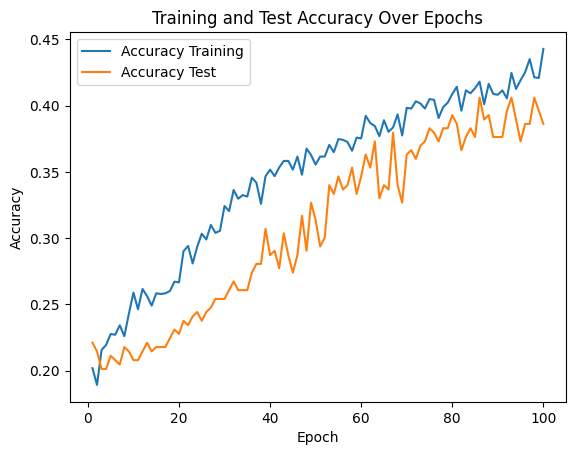

In [148]:
plot_accuracy(history_train_accuracy, history_test_accuracy)

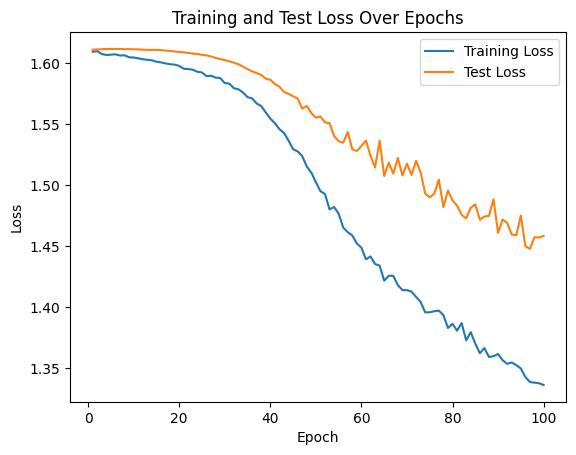

In [149]:
plot_loss(history_train_loss, history_test_loss)

# Evaluate Model

In [144]:
def evaluateModel(model, dataloader, criterion):
    model.eval()
    all_predictions = []
    all_targets = []
    all_outputs = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            all_outputs.append(outputs.softmax(dim=1))
            _, predictions = torch.max(outputs, dim=1)
            all_predictions.extend(predictions.tolist())
            labels = torch.argmax(labels, dim=1)
            all_targets.extend(labels.tolist())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    all_outputs = torch.cat(all_outputs)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_predictions)
    precision_micro = precision_score(all_targets, all_predictions, average='micro', zero_division=1)
    precision_macro = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
    recall_micro = recall_score(all_targets, all_predictions, average='micro', zero_division=1)
    recall_macro = recall_score(all_targets, all_predictions, average='macro', zero_division=1)
    f1_micro = f1_score(all_targets, all_predictions, average='micro', zero_division=1)
    f1_macro = f1_score(all_targets, all_predictions, average='macro', zero_division=1)
    auc = roc_auc_score(all_targets, all_outputs, multi_class='ovo')
    cm = confusion_matrix(all_targets, all_predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    avg_loss = running_loss / len(dataloader)

    return (accuracy, precision_micro, precision_macro, recall_micro, recall_macro, f1_micro, f1_macro, auc, avg_loss), cm

def summarizeEvaluation(model, test_loader, train_loader=None, validation_loader=None, show=None, show_train=None, show_validation=None):
    results = {}
    class_names=['bald', 'stage3', 'stage1', 'stage2', 'normal']

    # Evaluation for test set
    test_results, test_cm = evaluateModel(model, test_loader, criterion)
    results['Test'] = test_results

    # Evaluation for validation set
    if validation_loader is not None:
        validation_results, validation_cm = evaluateModel(model, validation_loader, criterion)
        results['Validation'] = validation_results

    # Evaluation for training set
    if train_loader is not None:
        train_results, train_cm = evaluateModel(model, train_loader, criterion)
        results['Train'] = train_results

    # Creazione del DataFrame
    df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision (Micro)', 'Precision (Macro)',
                                                                  'Recall (Micro)', 'Recall (Macro)', 'F1 Score (Micro)',
                                                                  'F1 Score (Macro)', 'AUC', 'Loss'])
    if show is not None:

        if test_cm is not None:
            plt.figure(figsize=(8, 6))
            sns.heatmap(test_cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix (Test)')
            plt.show()

        if show_validation is not None:
            plt.figure(figsize=(8, 6))
            sns.heatmap(validation_cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix (Validation)')
            plt.show()

        if show_train is not None:
            plt.figure(figsize=(8, 6))
            sns.heatmap(train_cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix (Train)')
            plt.show()

    return df

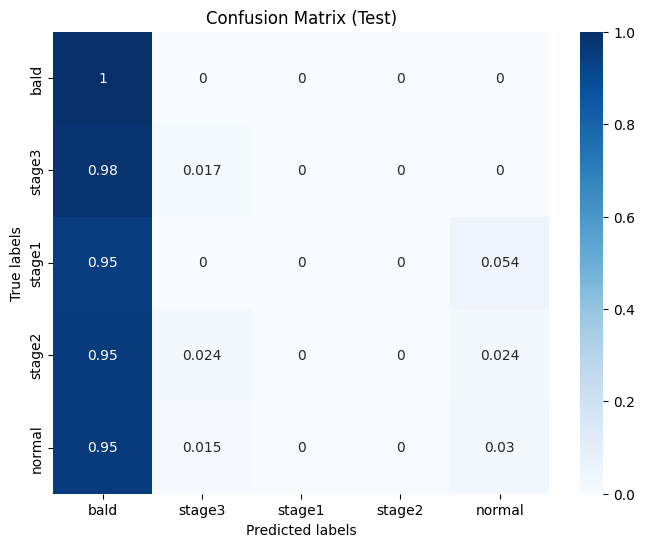

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.145215,0.145215,0.535225,0.145215,0.209509,0.145215,0.066660,0.595106,1.610312
Train,0.227647,0.227647,0.457998,0.227647,0.217142,0.227647,0.109522,0.613249,1.605542


In [145]:
df = summarizeEvaluation(model_1, test_loader, train_loader, show=True)
df

## Plot Results

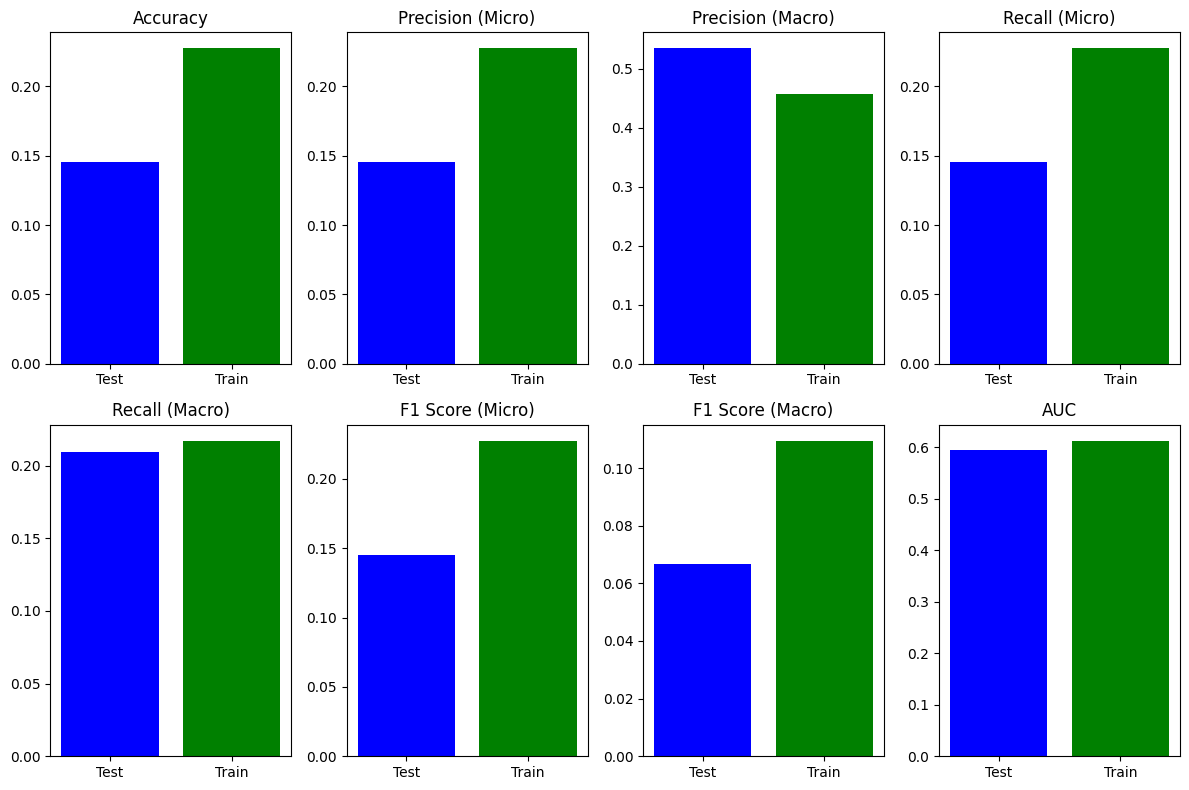

In [150]:
labels = df.index.tolist()

# Plot
plt.figure(figsize=(12, 8))

for i, column in enumerate(df.drop(['Loss'], axis=1).columns):
    plt.subplot(2, 4, i+1)
    plt.bar(labels, df[column], color=['blue', 'green', 'red'])
    plt.title(column)

plt.tight_layout()
plt.show()

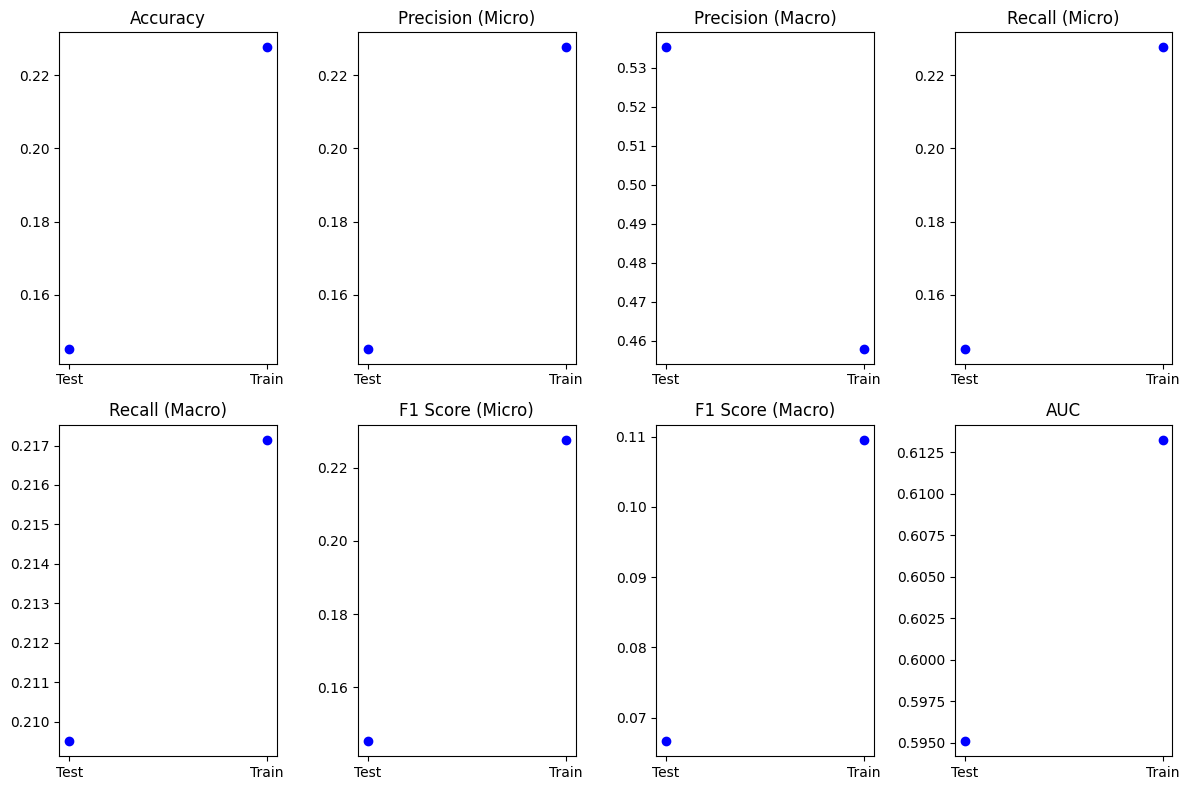

In [151]:
plt.figure(figsize=(12, 8))

for i, column in enumerate(df.drop(['Loss'], axis=1).columns):
    plt.subplot(2, 4, i+1)
    plt.scatter(labels, df[column], color='blue')
    plt.title(column)

plt.tight_layout()
plt.show()

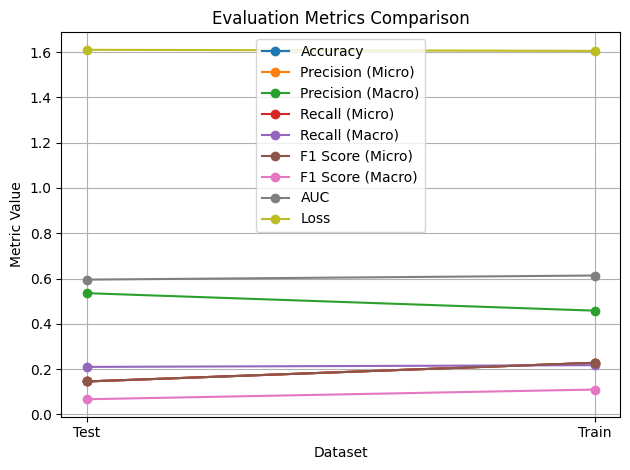

In [152]:
for column in df.columns:
    plt.plot(labels, df[column], marker='o')

plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics Comparison')
plt.legend(df.columns)

plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

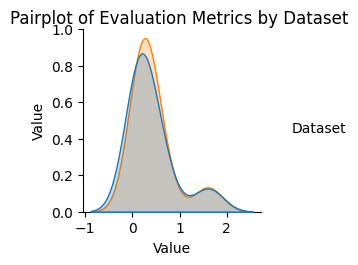

In [153]:
df['Dataset'] = df.index

metrics_melted = df.melt(id_vars='Dataset', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 10))
sns.pairplot(metrics_melted, hue='Dataset', markers=['o', 's', 'D'], diag_kind='kde')
plt.suptitle('Pairplot of Evaluation Metrics by Dataset', y=1.02);

**Overfitting model**

### 1 Model With Gray Scale

In [123]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=32, grayscale=True)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
train_loader, test_loader = defineDataLoader2(X_train_normalize, X_test_normalize, y_train, y_test, batch_size=32)

In [140]:
class CNN_1_Gray(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.flat = nn.Flatten()
        self.fc3 = nn.Linear(9248, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 5)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

In [141]:
model_1_gray = CNN_1_Gray()
model_1_gray

CNN_1_Gray(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=9248, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=5, bias=True)
)

In [142]:
summary(model_1_gray, (32, 32, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 17, 17]               0
           Flatten-7                 [-1, 9248]               0
            Linear-8                  [-1, 512]       4,735,488
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 5]           2,565
Total params: 4,747,621
Trainable params: 4,747,621
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
model_1_gray = CNN_1_Gray()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_gray.parameters(), lr=0.01, weight_decay = 0.001)
history = trainModel(model_1_gray, train_loader, criterion, optimizer, num_epochs=100)

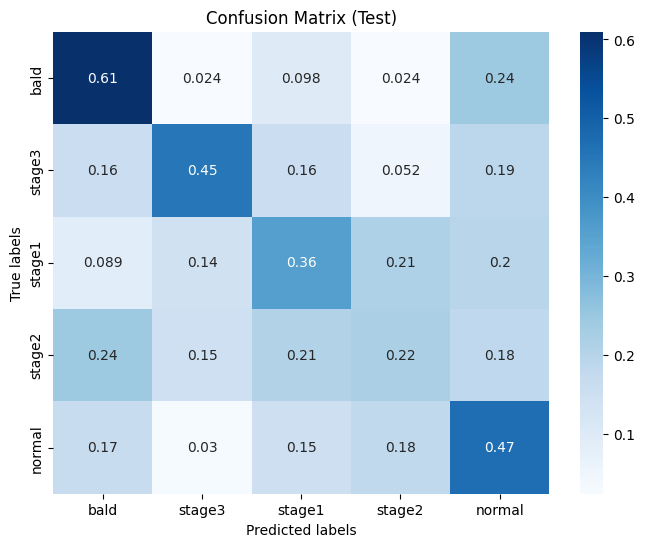

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.396040,0.396040,0.401966,0.396040,0.420877,0.396040,0.398613,0.717836,1.515892
Train,0.749863,0.749863,0.751969,0.749863,0.746857,0.749863,0.745976,0.943124,0.750882


In [145]:
df_1b = summarizeEvaluation(model_1_gray, test_loader, train_loader, show=True)
df_1b

# Training other architecture and pre-processing

## With resize 50x50 images

In [169]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=50)
train_loader, validation_loader, test_loader = defineDataLoader(X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation, batch_size=32)

In [179]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(160000, 512)
        self.act4 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.act1(self.conv1(x))
        x = self.bn1(x)
        x = self.act2(self.conv2(x))
        x = self.bn2(x)
        x = self.act3(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.drop(x)
        x = self.act4(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [180]:
model_2 = CNN_2()
model_2

CNN_2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=160000, out_features=512, bias=True)
  (act4): ReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [181]:
summary(model_2, (50, 50, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
              ReLU-2           [-1, 64, 50, 50]               0
       BatchNorm2d-3           [-1, 64, 50, 50]             128
            Conv2d-4          [-1, 128, 50, 50]          73,856
              ReLU-5          [-1, 128, 50, 50]               0
       BatchNorm2d-6          [-1, 128, 50, 50]             256
            Conv2d-7          [-1, 256, 50, 50]         295,168
              ReLU-8          [-1, 256, 50, 50]               0
       BatchNorm2d-9          [-1, 256, 50, 50]             512
        MaxPool2d-10          [-1, 256, 25, 25]               0
          Flatten-11               [-1, 160000]               0
          Dropout-12               [-1, 160000]               0
           Linear-13                  [-1, 512]      81,920,512
             ReLU-14                  [

In [183]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
# 1 houre
history = trainModel(model_2, train_loader, criterion, optimizer, num_epochs=10)
#torch.save(model_2, 'model2.pth')
#model_2 = torch.load('model2.pth')

Epoch 1/10: 100%|██████████| 48/48 [02:44<00:00,  3.42s/it]


Epoch [1/10], Training Loss: 12.751557561258474


Epoch 2/10: 100%|██████████| 48/48 [02:23<00:00,  2.98s/it]


Epoch [2/10], Training Loss: 1.898173655072848


Epoch 3/10: 100%|██████████| 48/48 [02:31<00:00,  3.16s/it]


Epoch [3/10], Training Loss: 1.5286156659324963


Epoch 4/10: 100%|██████████| 48/48 [02:38<00:00,  3.30s/it]


Epoch [4/10], Training Loss: 1.4866809323430061


Epoch 5/10: 100%|██████████| 48/48 [02:45<00:00,  3.44s/it]


Epoch [5/10], Training Loss: 1.5036309510469437


Epoch 6/10: 100%|██████████| 48/48 [03:29<00:00,  4.36s/it]


Epoch [6/10], Training Loss: 1.4930879125992458


Epoch 7/10: 100%|██████████| 48/48 [03:05<00:00,  3.86s/it]


Epoch [7/10], Training Loss: 1.4224735672275226


Epoch 8/10: 100%|██████████| 48/48 [03:09<00:00,  3.94s/it]


Epoch [8/10], Training Loss: 1.4293589442968369


Epoch 9/10: 100%|██████████| 48/48 [02:39<00:00,  3.33s/it]


Epoch [9/10], Training Loss: 1.3773273527622223


Epoch 10/10: 100%|██████████| 48/48 [02:44<00:00,  3.43s/it]

Epoch [10/10], Training Loss: 1.329375483095646


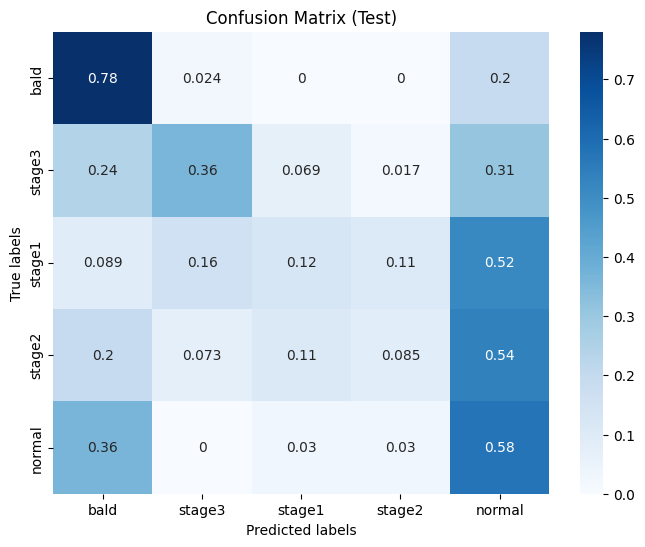

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.346535,0.346535,0.390454,0.346535,0.385736,0.346535,0.324736,0.692966,1.551674
Train,0.470085,0.470085,0.520018,0.470085,0.468795,0.470085,0.446611,0.810693,1.169497


In [185]:
df_2 = summarizeEvaluation(model_2, test_loader, train_loader, show=True)
df_2

## Another architecture

### Resize 100x100 with grayscale

In [155]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=100, grayscale=True)
train_loader, validation_loader, test_loader = defineDataLoader(X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation, batch_size=32)

In [156]:
class CNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 5)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = x.view(-1, 1, 100, 100)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool(x)
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool(x)
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [157]:
model_3 = CNN_3()
model_3

CNN_3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=5, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

In [158]:
summary(model_3, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             320
       BatchNorm2d-2         [-1, 32, 100, 100]              64
         MaxPool2d-3           [-1, 32, 50, 50]               0
            Conv2d-4           [-1, 64, 50, 50]          18,496
       BatchNorm2d-5           [-1, 64, 50, 50]             128
         MaxPool2d-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 25, 25]          73,856
       BatchNorm2d-8          [-1, 128, 25, 25]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 6, 6]       1,180,160
      BatchNorm2d-14            [-1, 51

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.01)
trainModel(model_3, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 48/48 [00:42<00:00,  1.13it/s]


Epoch [1/10], Training Loss: 1.5657704944411914


Epoch 2/10: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch [2/10], Training Loss: 1.434935376048088


Epoch 3/10: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch [3/10], Training Loss: 1.3930070673425992


Epoch 4/10: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch [4/10], Training Loss: 1.3515409504373868


Epoch 5/10: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]


Epoch [5/10], Training Loss: 1.3291132127245266


Epoch 6/10: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]


Epoch [6/10], Training Loss: 1.298080454270045


Epoch 7/10: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch [7/10], Training Loss: 1.2628923604885738


Epoch 8/10: 100%|██████████| 48/48 [00:38<00:00,  1.25it/s]


Epoch [8/10], Training Loss: 1.241383430858453


Epoch 9/10: 100%|██████████| 48/48 [00:41<00:00,  1.14it/s]


Epoch [9/10], Training Loss: 1.212770304332177


Epoch 10/10: 100%|██████████| 48/48 [00:42<00:00,  1.13it/s]

Epoch [10/10], Training Loss: 1.2059557835261028


[1.5657704944411914,
 1.434935376048088,
 1.3930070673425992,
 1.3515409504373868,
 1.3291132127245266,
 1.298080454270045,
 1.2628923604885738,
 1.241383430858453,
 1.212770304332177,
 1.2059557835261028]

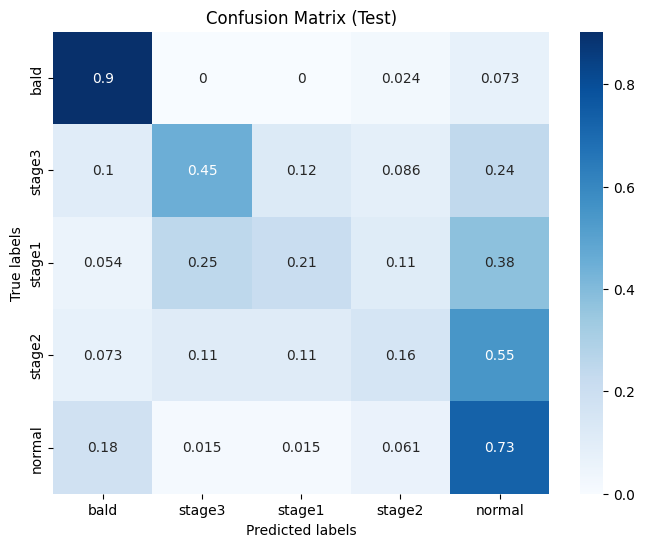

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.448845,0.448845,0.465321,0.448845,0.490162,0.448845,0.438028,0.804270,1.253534
Train,0.486522,0.486522,0.462450,0.486522,0.485420,0.486522,0.446173,0.818899,1.155073


In [160]:
df_3 = summarizeEvaluation(model_3, test_loader, train_loader, show=True)
df_3

### Simpliest CNN

In [339]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=50, grayscale=True)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)

In [340]:
train_loader, test_loader = defineDataLoader2(X_train_normalize, X_test_normalize, y_train, y_test, batch_size=32)

In [341]:
class SimplestCNN(nn.Module):
    def __init__(self):
        super(SimplestCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(20000, 5)

    def forward(self, x):
        x = x.view(-1, 1, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [342]:
model_simply = SimplestCNN()
model_simply

SimplestCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [343]:
summary(model_simply, (1, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             320
         MaxPool2d-2           [-1, 32, 25, 25]               0
            Linear-3                    [-1, 5]         100,005
Total params: 100,325
Trainable params: 100,325
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.76
Params size (MB): 0.38
Estimated Total Size (MB): 1.16
----------------------------------------------------------------


In [344]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_simply.parameters(), lr=0.01, weight_decay=0.01)
history_train_loss, history_test_loss, history_train_accuracy, history_test_accuracy = trainModel(model_simply, train_loader, test_loader, criterion, optimizer, num_epochs=300)

Epoch 1/300: 100%|██████████| 57/57 [00:01<00:00, 52.34it/s, train_loss=1.51]


Epoch [1/300], Train Loss: 1.7847, Train Acc: 0.2397, Test Loss: 1.5600, Test Acc: 0.2343


Epoch 2/300: 100%|██████████| 57/57 [00:01<00:00, 51.28it/s, train_loss=1.48]


Epoch [2/300], Train Loss: 1.5369, Train Acc: 0.3012, Test Loss: 1.5689, Test Acc: 0.2706


Epoch 3/300: 100%|██████████| 57/57 [00:01<00:00, 48.50it/s, train_loss=1.33]


Epoch [3/300], Train Loss: 1.4640, Train Acc: 0.3412, Test Loss: 1.6463, Test Acc: 0.2607


Epoch 4/300: 100%|██████████| 57/57 [00:01<00:00, 55.88it/s, train_loss=1.53]


Epoch [4/300], Train Loss: 1.4229, Train Acc: 0.3988, Test Loss: 1.5227, Test Acc: 0.3300


Epoch 5/300: 100%|██████████| 57/57 [00:01<00:00, 45.19it/s, train_loss=1.43]


Epoch [5/300], Train Loss: 1.3909, Train Acc: 0.3988, Test Loss: 1.5525, Test Acc: 0.2805


Epoch 6/300: 100%|██████████| 57/57 [00:01<00:00, 43.76it/s, train_loss=1.36]


Epoch [6/300], Train Loss: 1.3839, Train Acc: 0.3906, Test Loss: 1.5311, Test Acc: 0.3531


Epoch 7/300: 100%|██████████| 57/57 [00:01<00:00, 51.80it/s, train_loss=1.31]


Epoch [7/300], Train Loss: 1.3464, Train Acc: 0.4328, Test Loss: 1.5060, Test Acc: 0.3729


Epoch 8/300: 100%|██████████| 57/57 [00:01<00:00, 48.68it/s, train_loss=1.4] 


Epoch [8/300], Train Loss: 1.3258, Train Acc: 0.4399, Test Loss: 1.5329, Test Acc: 0.3267


Epoch 9/300: 100%|██████████| 57/57 [00:01<00:00, 42.40it/s, train_loss=1.16]


Epoch [9/300], Train Loss: 1.3059, Train Acc: 0.4630, Test Loss: 1.4942, Test Acc: 0.3531


Epoch 10/300: 100%|██████████| 57/57 [00:01<00:00, 40.72it/s, train_loss=1.29]


Epoch [10/300], Train Loss: 1.2903, Train Acc: 0.4696, Test Loss: 1.4761, Test Acc: 0.3993


Epoch 11/300: 100%|██████████| 57/57 [00:01<00:00, 54.08it/s, train_loss=1.15]


Epoch [11/300], Train Loss: 1.2737, Train Acc: 0.4761, Test Loss: 1.5290, Test Acc: 0.3597


Epoch 12/300: 100%|██████████| 57/57 [00:00<00:00, 58.04it/s, train_loss=1.25]


Epoch [12/300], Train Loss: 1.2625, Train Acc: 0.4756, Test Loss: 1.4745, Test Acc: 0.3861


Epoch 13/300: 100%|██████████| 57/57 [00:01<00:00, 54.32it/s, train_loss=1.3]  


Epoch [13/300], Train Loss: 1.2516, Train Acc: 0.4811, Test Loss: 1.4626, Test Acc: 0.4158


Epoch 14/300: 100%|██████████| 57/57 [00:01<00:00, 37.93it/s, train_loss=1.37] 


Epoch [14/300], Train Loss: 1.2349, Train Acc: 0.4981, Test Loss: 1.4672, Test Acc: 0.3729


Epoch 15/300: 100%|██████████| 57/57 [00:01<00:00, 51.69it/s, train_loss=1.16] 


Epoch [15/300], Train Loss: 1.2231, Train Acc: 0.5058, Test Loss: 1.4325, Test Acc: 0.3729


Epoch 16/300: 100%|██████████| 57/57 [00:01<00:00, 55.02it/s, train_loss=1.35] 


Epoch [16/300], Train Loss: 1.2219, Train Acc: 0.4942, Test Loss: 1.4667, Test Acc: 0.3234


Epoch 17/300: 100%|██████████| 57/57 [00:00<00:00, 57.98it/s, train_loss=1.18] 


Epoch [17/300], Train Loss: 1.1973, Train Acc: 0.5134, Test Loss: 1.4537, Test Acc: 0.3861


Epoch 18/300: 100%|██████████| 57/57 [00:01<00:00, 51.71it/s, train_loss=1.27] 


Epoch [18/300], Train Loss: 1.2054, Train Acc: 0.5052, Test Loss: 1.4555, Test Acc: 0.3894


Epoch 19/300: 100%|██████████| 57/57 [00:01<00:00, 52.62it/s, train_loss=1.02]


Epoch [19/300], Train Loss: 1.1849, Train Acc: 0.5167, Test Loss: 1.5026, Test Acc: 0.3795


Epoch 20/300: 100%|██████████| 57/57 [00:01<00:00, 56.90it/s, train_loss=1.13] 


Epoch [20/300], Train Loss: 1.1674, Train Acc: 0.5420, Test Loss: 1.4541, Test Acc: 0.3597


Epoch 21/300: 100%|██████████| 57/57 [00:00<00:00, 57.68it/s, train_loss=1.1]  


Epoch [21/300], Train Loss: 1.1507, Train Acc: 0.5540, Test Loss: 1.5407, Test Acc: 0.3630


Epoch 22/300: 100%|██████████| 57/57 [00:01<00:00, 46.20it/s, train_loss=1.12] 


Epoch [22/300], Train Loss: 1.1486, Train Acc: 0.5485, Test Loss: 1.5160, Test Acc: 0.3597


Epoch 23/300: 100%|██████████| 57/57 [00:01<00:00, 55.78it/s, train_loss=1.13] 


Epoch [23/300], Train Loss: 1.1440, Train Acc: 0.5409, Test Loss: 1.4355, Test Acc: 0.3960


Epoch 24/300: 100%|██████████| 57/57 [00:01<00:00, 42.04it/s, train_loss=1.19] 


Epoch [24/300], Train Loss: 1.1242, Train Acc: 0.5590, Test Loss: 1.4060, Test Acc: 0.4257


Epoch 25/300: 100%|██████████| 57/57 [00:00<00:00, 57.04it/s, train_loss=1.08] 


Epoch [25/300], Train Loss: 1.1240, Train Acc: 0.5590, Test Loss: 1.4667, Test Acc: 0.3861


Epoch 26/300: 100%|██████████| 57/57 [00:01<00:00, 56.62it/s, train_loss=1.16] 


Epoch [26/300], Train Loss: 1.1152, Train Acc: 0.5710, Test Loss: 1.3838, Test Acc: 0.4257


Epoch 27/300: 100%|██████████| 57/57 [00:01<00:00, 42.17it/s, train_loss=1.16] 


Epoch [27/300], Train Loss: 1.1123, Train Acc: 0.5721, Test Loss: 1.5302, Test Acc: 0.3762


Epoch 28/300: 100%|██████████| 57/57 [00:01<00:00, 46.90it/s, train_loss=1.11] 


Epoch [28/300], Train Loss: 1.0965, Train Acc: 0.5782, Test Loss: 1.4259, Test Acc: 0.3894


Epoch 29/300: 100%|██████████| 57/57 [00:01<00:00, 54.54it/s, train_loss=1.36] 


Epoch [29/300], Train Loss: 1.0840, Train Acc: 0.5935, Test Loss: 1.4788, Test Acc: 0.3564


Epoch 30/300: 100%|██████████| 57/57 [00:00<00:00, 57.98it/s, train_loss=1.16] 


Epoch [30/300], Train Loss: 1.0823, Train Acc: 0.5891, Test Loss: 1.4053, Test Acc: 0.4092


Epoch 31/300: 100%|██████████| 57/57 [00:01<00:00, 43.55it/s, train_loss=1.15] 


Epoch [31/300], Train Loss: 1.0718, Train Acc: 0.5985, Test Loss: 1.4885, Test Acc: 0.4026


Epoch 32/300: 100%|██████████| 57/57 [00:01<00:00, 55.06it/s, train_loss=1.12] 


Epoch [32/300], Train Loss: 1.0638, Train Acc: 0.5864, Test Loss: 1.4559, Test Acc: 0.3927


Epoch 33/300: 100%|██████████| 57/57 [00:01<00:00, 53.04it/s, train_loss=1.01] 


Epoch [33/300], Train Loss: 1.0496, Train Acc: 0.6067, Test Loss: 1.4410, Test Acc: 0.4026


Epoch 34/300: 100%|██████████| 57/57 [00:01<00:00, 48.76it/s, train_loss=1.17] 


Epoch [34/300], Train Loss: 1.0488, Train Acc: 0.5996, Test Loss: 1.4180, Test Acc: 0.3894


Epoch 35/300: 100%|██████████| 57/57 [00:00<00:00, 58.03it/s, train_loss=1.04] 


Epoch [35/300], Train Loss: 1.0489, Train Acc: 0.6094, Test Loss: 1.4443, Test Acc: 0.3960


Epoch 36/300: 100%|██████████| 57/57 [00:00<00:00, 59.17it/s, train_loss=1.08] 


Epoch [36/300], Train Loss: 1.0293, Train Acc: 0.6160, Test Loss: 1.4084, Test Acc: 0.4026


Epoch 37/300: 100%|██████████| 57/57 [00:01<00:00, 43.39it/s, train_loss=1.04] 


Epoch [37/300], Train Loss: 1.0225, Train Acc: 0.6182, Test Loss: 1.4950, Test Acc: 0.3729


Epoch 38/300: 100%|██████████| 57/57 [00:01<00:00, 53.40it/s, train_loss=0.895]


Epoch [38/300], Train Loss: 1.0080, Train Acc: 0.6259, Test Loss: 1.3953, Test Acc: 0.4092


Epoch 39/300: 100%|██████████| 57/57 [00:01<00:00, 53.80it/s, train_loss=0.959]


Epoch [39/300], Train Loss: 1.0080, Train Acc: 0.6221, Test Loss: 1.4031, Test Acc: 0.4257


Epoch 40/300: 100%|██████████| 57/57 [00:01<00:00, 43.39it/s, train_loss=0.862]


Epoch [40/300], Train Loss: 1.0025, Train Acc: 0.6188, Test Loss: 1.4192, Test Acc: 0.4158


Epoch 41/300: 100%|██████████| 57/57 [00:01<00:00, 51.02it/s, train_loss=1.01] 


Epoch [41/300], Train Loss: 0.9951, Train Acc: 0.6231, Test Loss: 1.4201, Test Acc: 0.4257


Epoch 42/300: 100%|██████████| 57/57 [00:01<00:00, 46.47it/s, train_loss=0.832]


Epoch [42/300], Train Loss: 0.9893, Train Acc: 0.6275, Test Loss: 1.3989, Test Acc: 0.4092


Epoch 43/300: 100%|██████████| 57/57 [00:01<00:00, 53.48it/s, train_loss=1.13] 


Epoch [43/300], Train Loss: 0.9791, Train Acc: 0.6385, Test Loss: 1.4109, Test Acc: 0.4191


Epoch 44/300: 100%|██████████| 57/57 [00:01<00:00, 56.50it/s, train_loss=1.16] 


Epoch [44/300], Train Loss: 0.9744, Train Acc: 0.6374, Test Loss: 1.3963, Test Acc: 0.4257


Epoch 45/300: 100%|██████████| 57/57 [00:01<00:00, 49.94it/s, train_loss=0.828]


Epoch [45/300], Train Loss: 0.9650, Train Acc: 0.6396, Test Loss: 1.4466, Test Acc: 0.4125


Epoch 46/300: 100%|██████████| 57/57 [00:01<00:00, 51.54it/s, train_loss=0.978]


Epoch [46/300], Train Loss: 0.9520, Train Acc: 0.6511, Test Loss: 1.3939, Test Acc: 0.4323
Training stopped: no improvement for 20 consecutive epochs.


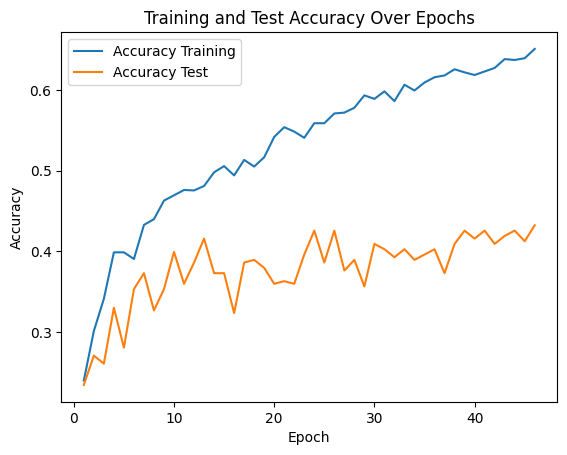

In [345]:
plot_accuracy(history_train_accuracy, history_test_accuracy)

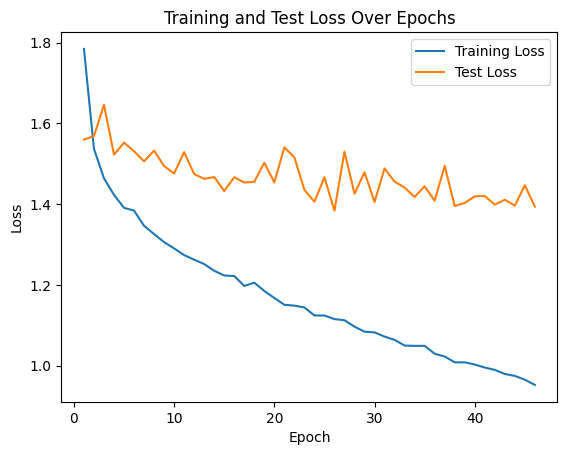

In [346]:
plot_loss(history_train_loss, history_test_loss)

In [335]:
df_4 = summarizeEvaluation(model_simply, test_loader, train_loader)
df_4

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.422442,0.422442,0.431200,0.422442,0.431948,0.422442,0.417002,0.736022,1.386486
Train,0.701042,0.701042,0.718065,0.701042,0.701639,0.701042,0.696504,0.926940,0.868832


# Load Pre-trained model ResNet50

In [301]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(dim_res=50)
train_loader, validation_loader, test_loader = defineDataLoader(batch_size=32)
train_loader.dataset.tensors[0].shape

torch.Size([1521, 50, 50])

In [309]:
# Add channel
def add_channel(images):
    return images.unsqueeze(1).repeat(1, 3, 1, 1)

train_images_with_channel = add_channel(train_loader.dataset.tensors[0])
train_dataset_with_channel = TensorDataset(train_images_with_channel, train_loader.dataset.tensors[1])
train_loader_with_channel = DataLoader(train_dataset_with_channel, batch_size=train_loader.batch_size, shuffle=True)

test_images_with_channel = add_channel(test_loader.dataset.tensors[0])
test_dataset_with_channel = TensorDataset(test_images_with_channel, test_loader.dataset.tensors[1])
test_loader_with_channel = DataLoader(test_dataset_with_channel, batch_size=test_loader.batch_size, shuffle=False)

In [327]:
test_loader_with_channel.dataset.tensors[0].shape

torch.Size([303, 3, 50, 50])

In [307]:
model_res = models.resnet50(pretrained=True)
num_classes = 5
num_features = model_res.fc.in_features
model_res.fc = nn.Linear(num_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_res.parameters(), lr=0.001)
trainModel(model_res, train_loader_with_channel, criterion, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 48/48 [00:59<00:00,  1.24s/it]


Training Loss: 53.47747874508301


Epoch 2/10: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Training Loss: 42.43542676915725


Epoch 3/10: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it]


Training Loss: 37.03196915984154


Epoch 4/10: 100%|██████████| 48/48 [00:51<00:00,  1.08s/it]


Training Loss: 32.54807795584202


Epoch 5/10: 100%|██████████| 48/48 [00:55<00:00,  1.16s/it]


Training Loss: 27.189081660161417


Epoch 6/10: 100%|██████████| 48/48 [00:56<00:00,  1.18s/it]


Training Loss: 24.80967894444863


Epoch 7/10: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Training Loss: 21.965206723039348


Epoch 8/10: 100%|██████████| 48/48 [00:53<00:00,  1.12s/it]


Training Loss: 15.39605982725819


Epoch 9/10: 100%|██████████| 48/48 [00:57<00:00,  1.20s/it]


Training Loss: 12.662864639734229


Epoch 10/10: 100%|██████████| 48/48 [00:57<00:00,  1.19s/it]

Training Loss: 13.202916550760468


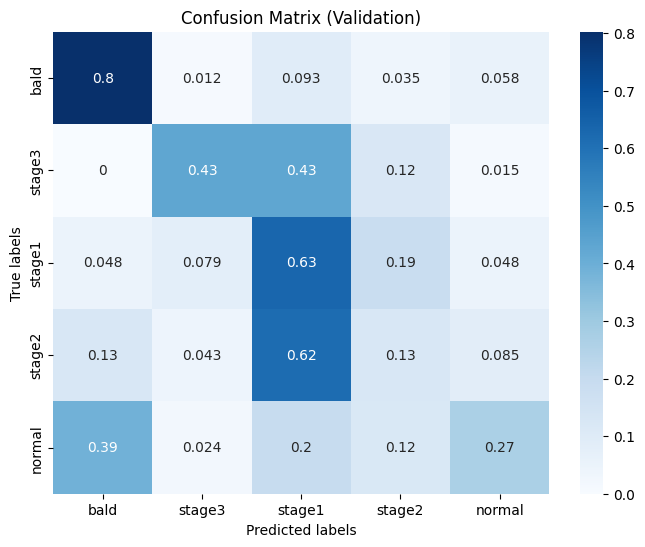

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Validation,0.509934,0.509934,0.495917,0.509934,0.452794,0.509934,0.451368,0.785233,1.609228
Test,0.904668,0.904668,0.914187,0.904668,0.904550,0.904668,0.904656,0.993574,0.265195
Train,0.415842,0.415842,0.458406,0.415842,0.464103,0.415842,0.418010,0.786368,1.994631


In [361]:
df_res = summarizeEvaluation(model_res, test_loader_with_channel, train_loader_with_channel, show=True)
df_res

# Load Pre-Trained VGG16

In [ ]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData(dim_res=32, grayscale=False)
train_loader, validation_loader, test_loader = defineDataLoader()

In [160]:
class VGG16_Weights(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_Weights, self).__init__()
        self.vgg16 = models.vgg16(weights=True)
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.vgg16(x)
        return x

In [ ]:
model_vgg = VGG16_Weights(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
# 90 min to train model
#trainModel(model_vgg, train_loader, criterion, optimizer, num_epochs=30)
#torch.save(model_vgg, 'model_vgg.pth')

In [ ]:
df_vgg = torch.load('model_vgg.pth')

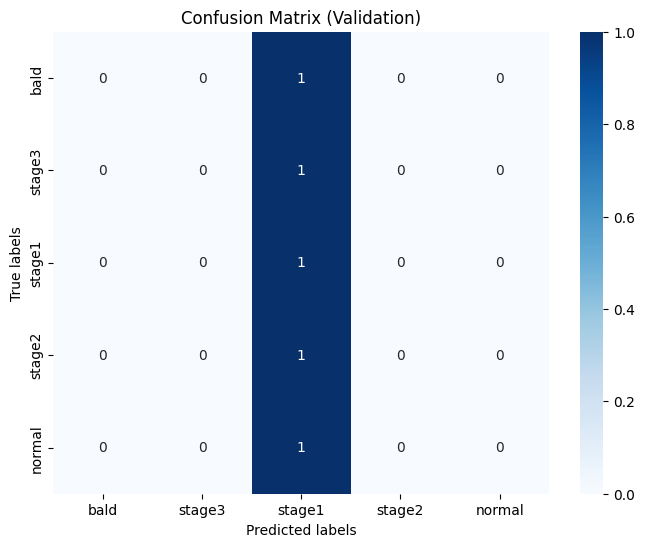

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Validation,0.208609,0.208609,0.841722,0.208609,0.2,0.208609,0.069041,0.5,1.616006
Test,0.201841,0.201841,0.840368,0.201841,0.2,0.201841,0.067177,0.5,1.610904
Train,0.184818,0.184818,0.836964,0.184818,0.2,0.184818,0.062396,0.5,1.611335


In [ ]:
df_vgg = summarizeEvaluation(model_vgg, test_loader, train_loader, show=True)
df_vgg

# SEGMENTATION

Define function to extract head and hair from photo

In [106]:
def findHead(dataset, labels, show_labels='training'):
    # Load the face detection classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    total_rows = len(dataset)
    hair_and_forehead_list = []
    filtered_labels = []
    for idx, image in tqdm(enumerate(dataset), total=total_rows, desc=f'Cropping Hair and Forehead of {show_labels} set'):
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        # Check if any faces are detected
        if len(faces) > 0:
            # Take only the first detected face
            (x, y, w, h) = faces[0]
            # Extend the cropped area to include part of the upper face
            extended_y = max(0, y - int(0.2 * h))
            extended_height = int(0.5 * h)
            # Crop the extended area to include hair
            hair_and_forehead = image[extended_y:extended_y+extended_height, x:x+w]
            hair_and_forehead_list.append(hair_and_forehead)
            filtered_labels.append(labels[idx])

    return hair_and_forehead_list, filtered_labels

In [107]:
train_res, train_labels_res = findHead(train_images, train_labels)
test_res, test_labels_res = findHead(test_images, test_labels, show_labels='test')
validation_res, validation_labels_res = findHead(validation_images, validation_labels, show_labels='validation')

Cropping Hair and Forehead of validation set: 100%|██████████| 302/302 [00:07<00:00, 40.99it/s]


In [169]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(train_res, test_res, validation_res,train_labels_res,test_labels_res,validation_labels_res, dim_res=32)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
train_loader, test_loader = defineDataLoader2(X_train_normalize, X_test_normalize, y_train, y_test, batch_size=32)

## With WGG16

In [171]:
model_vgg_2 = VGG16_Weights(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg_2.parameters(), lr=0.001)

In [172]:
history_train_loss, history_test_loss, history_train_accuracy, history_test_accuracy = trainModel(model_vgg_2, train_loader, test_loader, criterion, optimizer, num_epochs=40, patience=5)

Epoch 1/40: 100%|██████████| 56/56 [01:34<00:00,  1.68s/it, train_loss=1.49]


Epoch [1/40], Train Loss: 1.7424, Train Acc: 0.1995, Test Loss: 1.8226, Test Acc: 0.1356


Epoch 2/40: 100%|██████████| 56/56 [01:46<00:00,  1.90s/it, train_loss=1.66]


Epoch [2/40], Train Loss: 1.7178, Train Acc: 0.1893, Test Loss: 1.6413, Test Acc: 0.1356


Epoch 3/40: 100%|██████████| 56/56 [01:38<00:00,  1.76s/it, train_loss=1.66]


Epoch [3/40], Train Loss: 1.6161, Train Acc: 0.1967, Test Loss: 1.6206, Test Acc: 0.1356


Epoch 4/40: 100%|██████████| 56/56 [01:48<00:00,  1.93s/it, train_loss=1.64]


Epoch [4/40], Train Loss: 1.6147, Train Acc: 0.1961, Test Loss: 1.6261, Test Acc: 0.1356


Epoch 5/40: 100%|██████████| 56/56 [01:40<00:00,  1.79s/it, train_loss=1.67]


Epoch [5/40], Train Loss: 1.6154, Train Acc: 0.2018, Test Loss: 1.6090, Test Acc: 0.1898


Epoch 6/40: 100%|██████████| 56/56 [01:48<00:00,  1.93s/it, train_loss=1.62]


Epoch [6/40], Train Loss: 1.6125, Train Acc: 0.2052, Test Loss: 1.6056, Test Acc: 0.1898


Epoch 7/40: 100%|██████████| 56/56 [01:38<00:00,  1.76s/it, train_loss=1.54]


Epoch [7/40], Train Loss: 1.6134, Train Acc: 0.1973, Test Loss: 1.6181, Test Acc: 0.1898


Epoch 8/40: 100%|██████████| 56/56 [01:50<00:00,  1.97s/it, train_loss=1.55]


Epoch [8/40], Train Loss: 1.6129, Train Acc: 0.2052, Test Loss: 1.6172, Test Acc: 0.1898


Epoch 9/40: 100%|██████████| 56/56 [01:40<00:00,  1.79s/it, train_loss=1.67]


Epoch [9/40], Train Loss: 1.6166, Train Acc: 0.2001, Test Loss: 1.6166, Test Acc: 0.1898


Epoch 10/40: 100%|██████████| 56/56 [01:47<00:00,  1.92s/it, train_loss=1.58]


Epoch [10/40], Train Loss: 1.6152, Train Acc: 0.2007, Test Loss: 1.6017, Test Acc: 0.2169


Epoch 11/40: 100%|██████████| 56/56 [01:47<00:00,  1.91s/it, train_loss=1.64]


Epoch [11/40], Train Loss: 1.6156, Train Acc: 0.1922, Test Loss: 1.6098, Test Acc: 0.2169


Epoch 12/40: 100%|██████████| 56/56 [01:47<00:00,  1.93s/it, train_loss=1.66]


Epoch [12/40], Train Loss: 1.6154, Train Acc: 0.1933, Test Loss: 1.6215, Test Acc: 0.2169


Epoch 13/40: 100%|██████████| 56/56 [01:58<00:00,  2.11s/it, train_loss=1.66]


Epoch [13/40], Train Loss: 1.6160, Train Acc: 0.1910, Test Loss: 1.6230, Test Acc: 0.1356


Epoch 14/40: 100%|██████████| 56/56 [02:09<00:00,  2.32s/it, train_loss=1.57]


Epoch [14/40], Train Loss: 1.6108, Train Acc: 0.1973, Test Loss: 1.6156, Test Acc: 0.1898


Epoch 15/40: 100%|██████████| 56/56 [02:05<00:00,  2.24s/it, train_loss=1.58]


Epoch [15/40], Train Loss: 1.6121, Train Acc: 0.2080, Test Loss: 1.6472, Test Acc: 0.1356
Training stopped: no improvement for 5 consecutive epochs.


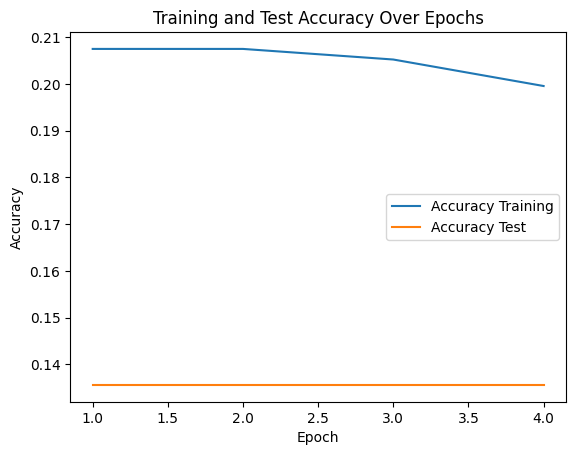

In [165]:
plot_accuracy(history_train_accuracy, history_test_accuracy)

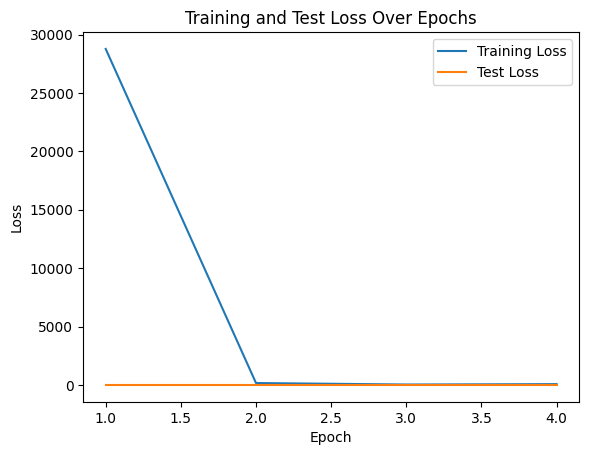

In [166]:
plot_loss(history_train_loss, history_test_loss)

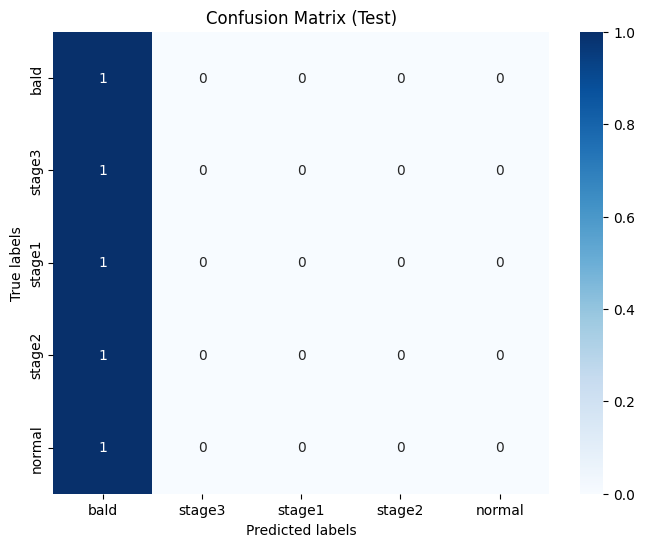

,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1 Score (Micro),F1 Score (Macro),AUC,Loss
Test,0.135593,0.135593,0.827119,0.135593,0.2,0.135593,0.047761,0.5,1.617209
Train,0.206916,0.206916,0.841383,0.206916,0.2,0.206916,0.068577,0.5,1.608750


In [168]:
df_vgg_2 = summarizeEvaluation(model_vgg_2, test_loader, train_loader, show=True)
df_vgg_2

## SVC

In [259]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(train_res, test_res, validation_res,train_labels_res,test_labels_res,validation_labels_res, dim_res=25, grayscale=True, preprocess_y=False)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
X_train, X_test = X_train_normalize.reshape(len(X_train_normalize), -1), X_test_normalize.reshape(len(X_test_normalize), -1)
X_train.shape

(1764, 625)

### Grid Search

In [261]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear']
}

svc = SVC(probability=True)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

In [262]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   1.6s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   1.7s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   1.6s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   1.7s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   1.7s
[CV] END .................C=0.001, gamma=0.01, kernel=linear; total time=   1.8s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   1.9s
[CV] END ..................C=0.001, gamma=0.1, 

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear']},
             scoring='accuracy', verbose=2)

In [263]:
grid_search.best_params_

{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

In [264]:
best_svc = grid_search.best_estimator_
best_svc.fit(X_train, y_train)

SVC(C=0.1, gamma=0.001, kernel='linear', probability=True)

In [265]:
y_pred = best_svc.predict(X_test)

In [266]:
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=1)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=1)
    return pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Micro)', 'Precision (Macro)',
                    'Recall (Micro)', 'Recall (Macro)', 'F1 Score (Micro)',
                    'F1 Score (Macro)'],
        'Score': [accuracy, precision, precision_macro, recall, recall_macro, f1, f1_macro]
    })

In [267]:
evaluate(y_test, y_pred)

,Metric,Score
0,Accuracy,0.359322
1,Precision (Micro),0.374768
2,Precision (Macro),0.370601
3,Recall (Micro),0.359322
4,Recall (Macro),0.386027
5,F1 Score (Micro),0.352532
6,F1 Score (Macro),0.359364


In [268]:
y_pred = best_svc.predict(X_train)
evaluate(y_train, y_pred)

,Metric,Score
0,Accuracy,0.530045
1,Precision (Micro),0.537469
2,Precision (Macro),0.537034
3,Recall (Micro),0.530045
4,Recall (Macro),0.527193
5,F1 Score (Micro),0.524710
6,F1 Score (Macro),0.523159


### RANDOM FOREST

In [ ]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(train_res, test_res, validation_res,train_labels_res,test_labels_res,validation_labels_res, dim_res=25, grayscale=True, preprocess_y=False)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
X_train, X_test = X_train_normalize.reshape(len(X_train_normalize), -1), X_test_normalize.reshape(len(X_test_normalize), -1)
X_train.shape

In [271]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

In [272]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END ma

{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300}

In [273]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=300)

In [274]:
best_rf.score(X_test, y_test)

0.3525423728813559

In [275]:
y_pred = best_rf.predict(X_test)
evaluate(y_test, y_pred)

,Metric,Score
0,Accuracy,0.352542
1,Precision (Micro),0.371962
2,Precision (Macro),0.365868
3,Recall (Micro),0.352542
4,Recall (Macro),0.375186
5,F1 Score (Micro),0.347441
6,F1 Score (Macro),0.352389


In [276]:
y_pred = best_rf.predict(X_train)
evaluate(y_train, y_pred)

,Metric,Score
0,Accuracy,0.982426
1,Precision (Micro),0.982927
2,Precision (Macro),0.983281
3,Recall (Micro),0.982426
4,Recall (Macro),0.982388
5,F1 Score (Micro),0.982547
6,F1 Score (Macro),0.982706


### XGBoost

In [347]:
X_train_normalize, X_test_normalize, X_validation_normalize, y_train, y_test, y_validation = mainProcessData2(train_res, test_res, validation_res,train_labels_res,test_labels_res,validation_labels_res, dim_res=32, grayscale=True, preprocess_y=False)
X_train_normalize = np.concatenate((X_train_normalize, X_validation_normalize), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)
X_train, X_test = X_train_normalize.reshape(len(X_train_normalize), -1), X_test_normalize.reshape(len(X_test_normalize), -1)
X_train.shape

(1764, 1024)

In [348]:
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

In [349]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  17.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  15.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  11.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  11.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  10.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  30.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  30.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  24.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  32.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  39.7s
[CV] END ..learning_rate=0.0

In [ ]:
y_pred = best_xgb.predict(X_test)
evaluate(y_test, y_pred)

In [ ]:
y_pred = best_xgb.predict(X_train)
evaluate(y_train, y_pred)